---
title: "Who is Exposed to Coastal Hazards in Puerto Rico?"
author: 
   - Deborah Balk 
   - Kytt MacManus
   - Hieu Tran 
   - Camilla Green 
   - Shemontee Chowdhury
format: 
    html
bibliography: lecz-references.bib
---


## Datasets:
- VIIRS Nighttime Lights
- LECZ
- NHGIS
- LiDAR SAR

## Areas of Interest (AOIs):
- Puerto Rico (PRI)

## Functions:
- Image segmentation
- Validation with SAR or LiDAR

# Overview

In this lesson, you will use a dataset delineating [Low Elevation Coastal Zones](https://sedac.ciesin.columbia.edu/data/set/lecz-low-elevation-coastal-zones) from the NASA Socioeconomic Data and Applications Center (SEDAC) website along with census data from the [US Census Bureau](https://www.census.gov/data.html) from the [IPUMS](https://www.ipums.org/) National Historical Geographic Information System (NHGIS). 

You will perform various preprocessing tasks to combina tabular and spatial boundary data for analysis. These steps include exploring the dataset with visualizations and thematic mapping tools. You will then learn how to generate summary statistics based on combinations of these two layers, over two different time periods. 

You will learn how to perform numerous data manipulations, create statistical summaries of population-at-risk (and related housing characteristics), and examine a decade of change throughout this lesson.

# Learning Objectives

- Become familiar with Census Block and County census data for 5-year age groups from the U.S. Census.
- Become familiar with Low Elevation Coastal Zones (LECZs) in Puerto Rico and explain their significance (as well as limitations) in assessing coastal hazard exposure.
- Access, integrate, explore, and use LECZ data from NASA SEDAC and demographic data from the US Census Bureau for Puerto Rico.
- Assess decadal changes (2010–2020) in population and housing characteristics in coastal versus non-coastal zones in Puerto Rico.
- Create regional and local scale maps and statistical figures of exposure and decadal change.
- Identify venues for sharing output (for example, discussion board associated with data, policy briefs, op-eds).

# Introduction

## Low Elevation Coastal Zones (LECZs)

Low Elevation Coastal Zones (LECZs) have been defined globally, with population estimates for areas below 5m and 10m elevations [@mcgranahan2007; @macmanus2021]. 

In the continental U.S. (CONUS), 1 in 10 people live in the 10m LECZ, and studies highlight that urban residents, people of color, and older adults are disproportionately exposed. For instance, about 1 in 5 urban Black residents live in this zone [@tagtachian2023; @hauer2020sea].

This is the sneak peak of what LECZ looks like:
![](data/lecz_pr/lecz_satellite.png)

You may wonder why studies of the “entire” US often restrict themselves to the CONUS? The simplest answer is limitations either data or computational power. For example, this happens because of incomplete coverage in one data set or another. Some US territories may not collect the full suite of census variables that are collected in CONUS. 

For example the detail on housing characteristics is limited in Guam, Northern Mariana Islands, US Virgin Islands and American Samoa, and the Census’ American Community Survey is not conducted in any of the territories, though Puerto Rico conducts its own Community Survey. In some other cases, data collected from satellites (such as SRTM) have variable accuracy toward polar regions [U.S Census Bureau](https://docs.google.com/document/d/1bKYopZoMLCD2djl2vc3pwNSKwGDk6TKRI79swefIvKY/edit?tab=t.0). 

Another possible reason for omission outside of CONUS could be computational challenges or limitations. For instance US territories are subject to different map projections, which implies the need for additional functions in processing algorithms to account for spatial variations and to unify spatial structures.

 
::: {.callout-tip style="color: #5a7a2b;"}
## Programming Reminder




### “What is a Map Projection?”

Map projections have existed for thousands of years. They help map makers render the spherical surface of the Earth flat -- so it can be seen on a piece of paper or computer screen, and so that the unit of measure is uniform throughout the area of interest. As a result, map projections distort something -- area, shape, distance, direction -- to make this possible. 

Here are some resources to learn more about map projections:

[A brief video explainer](https://www.youtube.com/watch?v=wlfLW1j05Dg)

[A brief guide from USGS](https://pubs.usgs.gov/gip/70047422/report.pdf)

There are many resources to guide a new learner, so enjoy learning! 



:::


# Accessing Data


This lesson uses the Python language. These are the equired packages to run this lesson `impumspy`, `pandas`, `arcgis`, `zipfile`, and `numpy`. Optional packages include `glob`, `geopandas`, and `earthaccess`.

Use `import` to import the necessary packages:


In [1]:
import arcgis
from arcgis.gis import GIS


# Standard libraries
import os
import glob
import re
from zipfile import ZipFile
from dotenv import load_dotenv
import pprint
import requests

# Data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import FuncFormatter

# Geospatial libraries
import geopandas as gpd
import arcgis
from arcgis.gis import GIS
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.raster import Raster
import arcgis.mapping  # For using WebMap, MapView, etc.

# Earthdata access
import earthaccess as ea

# IPUMS API and DDI access
from ipumspy.api import IpumsApiClient
from ipumspy import AggregateDataExtract, readers, ddi

from ipumspy import readers, ddi
from ipumspy.api import IpumsApiClient
from ipumspy import AggregateDataExtract

from ipumspy.api.extract import NhgisDataset

import seaborn as sns
import matplotlib.pyplot as plt


This lesson uses arcgis version of 2.4.0 or higher:


In [2]:
# Check the arcgis version for mapping properly 
arcgis.__version__

'2.4.1.1'

If arcgis version is lower, use `pip install`:


In [3]:
#| eval: false


pip install arcgis==2.4.1.1

## Using IPUMS API to pull U.S Census Data for Puerto Rico


### Registering to IPUMS and the National Historical Geographic Information System (NHGIS) 

In order to retrieve an IPUMS API Key, you will have to register for an account for IPUMS and request your [API Key](https://account.ipums.org/api_keys).

Additionally register, to [The National Historical Geographic Information System (NHGIS)](https://uma.pop.umn.edu/nhgis/registration)

After you requested your IPUMS API, to the NHGIS, store it in `os.env` format. You will need your registration email and the API Key:


In [4]:
#| eval: false


# Step 1: Load API key from .env file
load_dotenv()
IPUMS_API_KEY = os.getenv("EMAIL", "API_KEY")

if IPUMS_API_KEY is None:
    raise ValueError("API key not found. Make sure IPUMS_API_KEY is defined in your .env file.")

# Step 2: Initialize IPUMS client
ipums = IpumsApiClient(IPUMS_API_KEY)


In [5]:
#| echo: false


# Step 1: Load API key from .env file
load_dotenv()
IPUMS_API_KEY = os.getenv("jfm2205@columbia.edu", "59cba10d8a5da536fc06b59d0f22aac2b5f64a819df686fd2d47d0e4")

if IPUMS_API_KEY is None:
    raise ValueError("API key not found. Make sure IPUMS_API_KEY is defined in your .env file.")

# Step 2: Initialize IPUMS client
ipums = IpumsApiClient(IPUMS_API_KEY)


Getting shapefile metadata in order to get the filename for downloading the shapefile in the below chunk.

This block will be returning the shapefile name of interest so that we can download it in the next block


In [6]:
# After registering to NHGIS, please run this code

for page in ipums.get_metadata_catalog("nhgis", metadata_type="shapefiles"):
    for shapefile in page["data"]:
        if shapefile["extent"] == "Puerto Rico":
            if shapefile["geographicLevel"] == "Block Group" and shapefile["year"] == "2010":
                print( "Name: " + shapefile["name"] + " | Year: " + shapefile["year"])

Name: 720_blck_grp_2010_tl2010 | Year: 2010
Name: 720_blck_grp_2010_tl2020 | Year: 2010


### Downlaoding shapefiles from IPUMS

With this API key, we can extract geospatial data from the IPUMS API. Using the geo level `blck_grp`, we can speicify that we want to extract data at the Block Group level.


The `AggregateDataExtract` function specifies the collection to use, in this case NHGIS, give it a human-readable label for the extract request, and requests the 2010 and 2020 Summary File 1 (SF1a) dataset with tables P12 (sex by age) and H3 (vacancy status) at the block group geographic level. It also limits the extract to geographic extent code "720" (Puerto Rico).

Getting data from 2010 and 2020 with the variables for 5-year Age Groups (P12) and the Housing (H3). 


In [7]:
#| eval: false


# Submit extraction data to IPUMS portal
extract = AggregateDataExtract(
    collection="nhgis",  # Use NHGIS collection
    description="Puerto Rico 2010–2020 vacancy",  # Extract label
    datasets=[
        NhgisDataset(
            name="2010_SF1a",  # 2010 dataset
            data_tables=["P12", "H3"],  # Tables: sex by age, vacancy
            geog_levels=["blck_grp"]  # At block group level
        ),
        NhgisDataset(
            name="2020_DHCa",  # 2020 dataset
            data_tables=["P12", "H3"],  # Same tables
            geog_levels=["blck_grp"]  # Same level
        ),
    ],
    geographic_extents=["720"]  # Puerto Rico only
    # shapefiles=["720_blck_grp_2020_tl2020"]  # Optional: include shapefile
)


This code sends the extract request to IPUMS, prints the unique extract ID so you can track it, and sets up to wait until the extract is finished.


In [8]:
#| eval: false


# Submit the extract request
ipums.submit_extract(extract)  # Send request to IPUMS
print(f"Extract ID: {extract.extract_id}")  # Print the extract ID

# Wait for the extract to finish

This code sets up the folder where the extract will be saved, creates it if it doesn't already exist, and downloads the extract from IPUMS to that location:


In [9]:
#| eval: false


# Download the extract
current = os.getcwd()  # Get current working directory
DOWNLOAD_DIR = os.path.join(f"{current}/data/ipums/block")  # Set download path

os.makedirs(DOWNLOAD_DIR, exist_ok=True)  # Create folder if needed

ipums.download_extract(extract, download_dir=DOWNLOAD_DIR)  # Download files to folder

After downloading the extract, this code navigates to the download directory, identifies the ZIP file containing the CSV data, and inspects its contents. It then locates the specific CSV files for the years 2010 and 2020 using filename patterns, and reads them directly from the ZIP archive into pandas DataFrames—no need to manually unzip anything!

In [10]:
current = os.getcwd()  # Get current working directory
DOWNLOAD_DIR = os.path.join(f"{current}/data/ipums/block")  # Set path to downloaded extract
file_list = os.listdir(DOWNLOAD_DIR)  # List files in download folder
csv_zip = [f for f in file_list if f.endswith('_csv.zip')]  # Find ZIP with CSVs
csv = f"{DOWNLOAD_DIR}/{csv_zip[0]}"  # Get full path to ZIP

# Read zip data file in the extract
with ZipFile(csv) as z:
    csv_data = z.namelist()  # List files inside ZIP
    print("Contents of zip: ", csv_data)
    
    # Find the correct CSVs using filename patterns
    file_2020 = next(f for f in csv_data if '2020' in f and f.endswith('.csv'))  # 2020 file
    file_2010 = next(f for f in csv_data if '2010' in f and f.endswith('.csv'))  # 2010 file

    # Read CSVs into DataFrames
    with z.open(file_2020) as f:
        df_2020 = pd.read_csv(f)  # Load 2020 data

    with z.open(file_2010) as f:
        df_2010 = pd.read_csv(f)  # Load 2010 data


Contents of zip:  ['nhgis0012_csv/nhgis0012_ds258_2020_blck_grp_codebook.txt', 'nhgis0012_csv/nhgis0012_ds258_2020_blck_grp.csv', 'nhgis0012_csv/nhgis0012_ds172_2010_blck_grp.csv', 'nhgis0012_csv/nhgis0012_ds172_2010_blck_grp_codebook.txt']


This section uses NHGIS Codebook file(s) that were automatically included in your data extract to rename cryptic column codes in the 2010 and 2020 datasets to human-readable labels. These codes correspond to census tables on sex by age and housing occupancy. Renaming makes analysis and visualization much easier later in your workflow.

Look for the .txt file(s) in the zipped file you downloaded, and they will shed some light on your data.


In [11]:
# The NHGIS codes are as follows in the documentation which is downloaded from the IPUMS API 

# Rename columns for dataframe 2020

'''    Table 1:     Sex by Age for Selected Age Categories
    Universe:    Total population
    Source code: P12
    NHGIS code:  U7S
        U7S001:      Total
        U7S002:      Male
        U7S003:      Male: Under 5 years
        U7S004:      Male: 5 to 9 years
        U7S005:      Male: 10 to 14 years
        U7S006:      Male: 15 to 17 years
        U7S007:      Male: 18 and 19 years
        U7S008:      Male: 20 years
        U7S009:      Male: 21 years
        U7S010:      Male: 22 to 24 years
        U7S011:      Male: 25 to 29 years
        U7S012:      Male: 30 to 34 years
        U7S013:      Male: 35 to 39 years
        U7S014:      Male: 40 to 44 years
        U7S015:      Male: 45 to 49 years
        U7S016:      Male: 50 to 54 years
        U7S017:      Male: 55 to 59 years
        U7S018:      Male: 60 and 61 years
        U7S019:      Male: 62 to 64 years
        U7S020:      Male: 65 and 66 years
        U7S021:      Male: 67 to 69 years
        U7S022:      Male: 70 to 74 years
        U7S023:      Male: 75 to 79 years
        U7S024:      Male: 80 to 84 years
        U7S025:      Male: 85 years and over
        U7S026:      Female
        U7S027:      Female: Under 5 years
        U7S028:      Female: 5 to 9 years
        U7S029:      Female: 10 to 14 years
        U7S030:      Female: 15 to 17 years
        U7S031:      Female: 18 and 19 years
        U7S032:      Female: 20 years
        U7S033:      Female: 21 years
        U7S034:      Female: 22 to 24 years
        U7S035:      Female: 25 to 29 years
        U7S036:      Female: 30 to 34 years
        U7S037:      Female: 35 to 39 years
        U7S038:      Female: 40 to 44 years
        U7S039:      Female: 45 to 49 years
        U7S040:      Female: 50 to 54 years
        U7S041:      Female: 55 to 59 years
        U7S042:      Female: 60 and 61 years
        U7S043:      Female: 62 to 64 years
        U7S044:      Female: 65 and 66 years
        U7S045:      Female: 67 to 69 years
        U7S046:      Female: 70 to 74 years
        U7S047:      Female: 75 to 79 years
        U7S048:      Female: 80 to 84 years
        U7S049:      Female: 85 years and over
 
    Table 2:     Occupancy Status
    Universe:    Housing units
    Source code: H3
    NHGIS code:  U9X
        U9X001:      Total
        U9X002:      Occupied
        U9X003:      Vacant
'''


rename_2020 = {
    "U7S001": "Total_Population",
    "U7S002": "Male",
    "U7S003": "Male: Under 5 years",
    "U7S004": "Male: 5 to 9 years",
    "U7S005":      "Male: 10 to 14 years",
    "U7S006":      "Male: 15 to 17 years",
    "U7S007":      "Male: 18 and 19 years",
    "U7S008":      "Male: 20 years",
    "U7S009":      "Male: 21 years",
    "U7S010":      "Male: 22 to 24 years",
    "U7S011":      "Male: 25 to 29 years",
    "U7S012":      "Male: 30 to 34 years",
    "U7S013":      "Male: 35 to 39 years",
    "U7S014":      "Male: 40 to 44 years",
    "U7S015":      "Male: 45 to 49 years",
    "U7S016":      "Male: 50 to 54 years",
    "U7S017":      "Male: 55 to 59 years",
    "U7S018":      "Male: 60 and 61 years",
    "U7S019":      "Male: 62 to 64 years",
    "U7S020":      "Male: 65 and 66 years",
    "U7S021":      "Male: 67 to 69 years",
    "U7S022":      "Male: 70 to 74 years",
    "U7S023":      "Male: 75 to 79 years",
    "U7S024":      "Male: 80 to 84 years",
    "U7S025":      "Male: 85 years and over",
    "U7S026":      "Female",
    "U7S027":      "Female: Under 5 years",
    "U7S028":      "Female: 5 to 9 years",
    "U7S029":      "Female: 10 to 14 years",
    "U7S030":      "Female: 15 to 17 years",
    "U7S031":      "Female: 18 and 19 years",
    "U7S032":      "Female: 20 years",
    "U7S033":      "Female: 21 years",
    "U7S034":      "Female: 22 to 24 years",
    "U7S035":      "Female: 25 to 29 years",
    "U7S036":      "Female: 30 to 34 years",
    "U7S037":      "Female: 35 to 39 years",
    "U7S038":      "Female: 40 to 44 years",
    "U7S039":      "Female: 45 to 49 years",
    "U7S040":      "Female: 50 to 54 years",
    "U7S041":      "Female: 55 to 59 years",
    "U7S042":      "Female: 60 and 61 years",
    "U7S043":      "Female: 62 to 64 years",
    "U7S044":      "Female: 65 and 66 years",
    "U7S045":      "Female: 67 to 69 years",
    "U7S046":      "Female: 70 to 74 years",
    "U7S047":      "Female: 75 to 79 years",
    "U7S048":      "Female: 80 to 84 years",
    "U7S049":      "Female: 85 years and over",
    "U9X001": "Total_Housing_Units",
    "U9X002": "Occupied",
    "U9X003": "Vacant"
}

#Rename columns for dataframe 2010
'''    Table 1:     Housing Units
    Universe:    Housing units
    Source code: H1
    NHGIS code:  IFC
        IFC001:      Total
 
    Table 2:     Occupancy Status
    Universe:    Housing units
    Source code: H3
    NHGIS code:  IFE
        IFE001:      Total
        IFE002:      Occupied
        IFE003:      Vacant'''

rename_2010 = {
    "H76001": "Total_Population",
    "H76002": "Male",
    "H76003": "Male: Under 5 years",
    "H76004": "Male: 5 to 9 years",
    "H76005":      "Male: 10 to 14 years",
    "H76006":      "Male: 15 to 17 years",
    "H76007":      "Male: 18 and 19 years",
    "H76008":      "Male: 20 years",
    "H76009":      "Male: 21 years",
    "H76010":      "Male: 22 to 24 years",
    "H76011":      "Male: 25 to 29 years",
    "H76012":      "Male: 30 to 34 years",
    "H76013":      "Male: 35 to 39 years",
    "H76014":      "Male: 40 to 44 years",
    "H76015":      "Male: 45 to 49 years",
    "H76016":      "Male: 50 to 54 years",
    "H76017":      "Male: 55 to 59 years",
    "H76018":      "Male: 60 and 61 years",
    "H76019":      "Male: 62 to 64 years",
    "H76020":      "Male: 65 and 66 years",
    "H76021":      "Male: 67 to 69 years",
    "H76022":      "Male: 70 to 74 years",
    "H76023":      "Male: 75 to 79 years",
    "H76024":      "Male: 80 to 84 years",
    "H76025":      "Male: 85 years and over",
    "H76026":      "Female",
    "H76027":      "Female: Under 5 years",
    "H76028":      "Female: 5 to 9 years",
    "H76029":      "Female: 10 to 14 years",
    "H76030":      "Female: 15 to 17 years",
    "H76031":      "Female: 18 and 19 years",
    "H76032":      "Female: 20 years",
    "H76033":      "Female: 21 years",
    "H76034":      "Female: 22 to 24 years",
    "H76035":      "Female: 25 to 29 years",
    "H76036":      "Female: 30 to 34 years",
    "H76037":      "Female: 35 to 39 years",
    "H76038":      "Female: 40 to 44 years",
    "H76039":      "Female: 45 to 49 years",
    "H76040":      "Female: 50 to 54 years",
    "H76041":      "Female: 55 to 59 years",
    "H76042":      "Female: 60 and 61 years",
    "H76043":      "Female: 62 to 64 years",
    "H76044":      "Female: 65 and 66 years",
    "H76045":      "Female: 67 to 69 years",
    "H76046":      "Female: 70 to 74 years",
    "H76047":      "Female: 75 to 79 years",
    "H76048":      "Female: 80 to 84 years",
    "H76049":      "Female: 85 years and over",
    "IFC001": "Total_Housing",
    "IFE001": "Total_Housing_Units",
    "IFE002": "Occupied",
    "IFE003": "Vacant"
}



# Apply renaming to both datasets
df_2010.rename(columns=rename_2010, inplace=True)  # Rename 2010 columns
df_2020.rename(columns=rename_2020, inplace=True)  # Rename 2020 columns

This step filters both datasets to include only records from Puerto Rico, which is identified in the IPUMS data by `STATEA == 72`. It also removes any columns that are completely empty (all values are NaN), which helps clean up the data for analysis.

In [12]:
# Subset Puerto Rico (STATEA code 72)
pr_df_2010 = df_2010[df_2010["STATEA"] == 72]  # Filter 2010 data for Puerto Rico
pr_df_2020 = df_2020[df_2020["STATEA"] == 72]  # Filter 2020 data for Puerto Rico

# Drop columns with all missing values
pr_df_2010 = pr_df_2010.dropna(axis=1, how='all')  # Clean 2010 data
pr_df_2020 = pr_df_2020.dropna(axis=1, how='all')  # Clean 2020 data

This step calculates the total population aged 60 and over by summing the relevant male and female age group columns. It then computes two new indicators for both 2010 and 2020:

-   AgedRatio: the share of the total population that is 60+

-   VacantRatio: the share of housing units that are vacant

These ratios help measure aging and housing vacancy patterns in Puerto Rico over time.


In [13]:
# Define age columns for population 60+
pop60plus_cols = [
    "Female: 60 and 61 years",
    "Female: 62 to 64 years",
    "Female: 65 and 66 years",
    "Female: 67 to 69 years",
    "Female: 70 to 74 years",
    "Female: 75 to 79 years",
    "Female: 80 to 84 years",
    "Female: 85 years and over",
    "Male: 60 and 61 years",
    "Male: 62 to 64 years",
    "Male: 65 and 66 years",
    "Male: 67 to 69 years",
    "Male: 70 to 74 years",
    "Male: 75 to 79 years",
    "Male: 80 to 84 years",
    "Male: 85 years and over"
]

# Calculate totals and ratios for 2010
pr_df_2010["Pop60plus_total"] = pr_df_2010[pop60plus_cols].sum(axis=1)  # Sum 60+ pop
pr_df_2010["AgedRatio"] = pr_df_2010["Pop60plus_total"] / pr_df_2010["Total_Population"]  # 60+ share
pr_df_2010["VacantRatio"] = pr_df_2010["Vacant"] / pr_df_2010["Total_Housing_Units"]  # Vacancy share

# Calculate totals and ratios for 2020
pr_df_2020["Pop60plus_total"] = pr_df_2020[pop60plus_cols].sum(axis=1)
pr_df_2020["AgedRatio"] = pr_df_2020["Pop60plus_total"] / pr_df_2020["Total_Population"]
pr_df_2020["VacantRatio"] = pr_df_2020["Vacant"] / pr_df_2020["Total_Housing_Units"]


Lets create a scatter plot to explore the relationship between aging and housing vacancy in Puerto Rico in 2010. Each point represents a geographic unit (e.g., block group), where the x-axis shows the Vacant Ratio (share of housing units that are vacant), and the y-axis shows the Aged Ratio (share of population aged 60+).

This kind of visualization helps reveal spatial patterns or clusters related to population aging and housing dynamics.


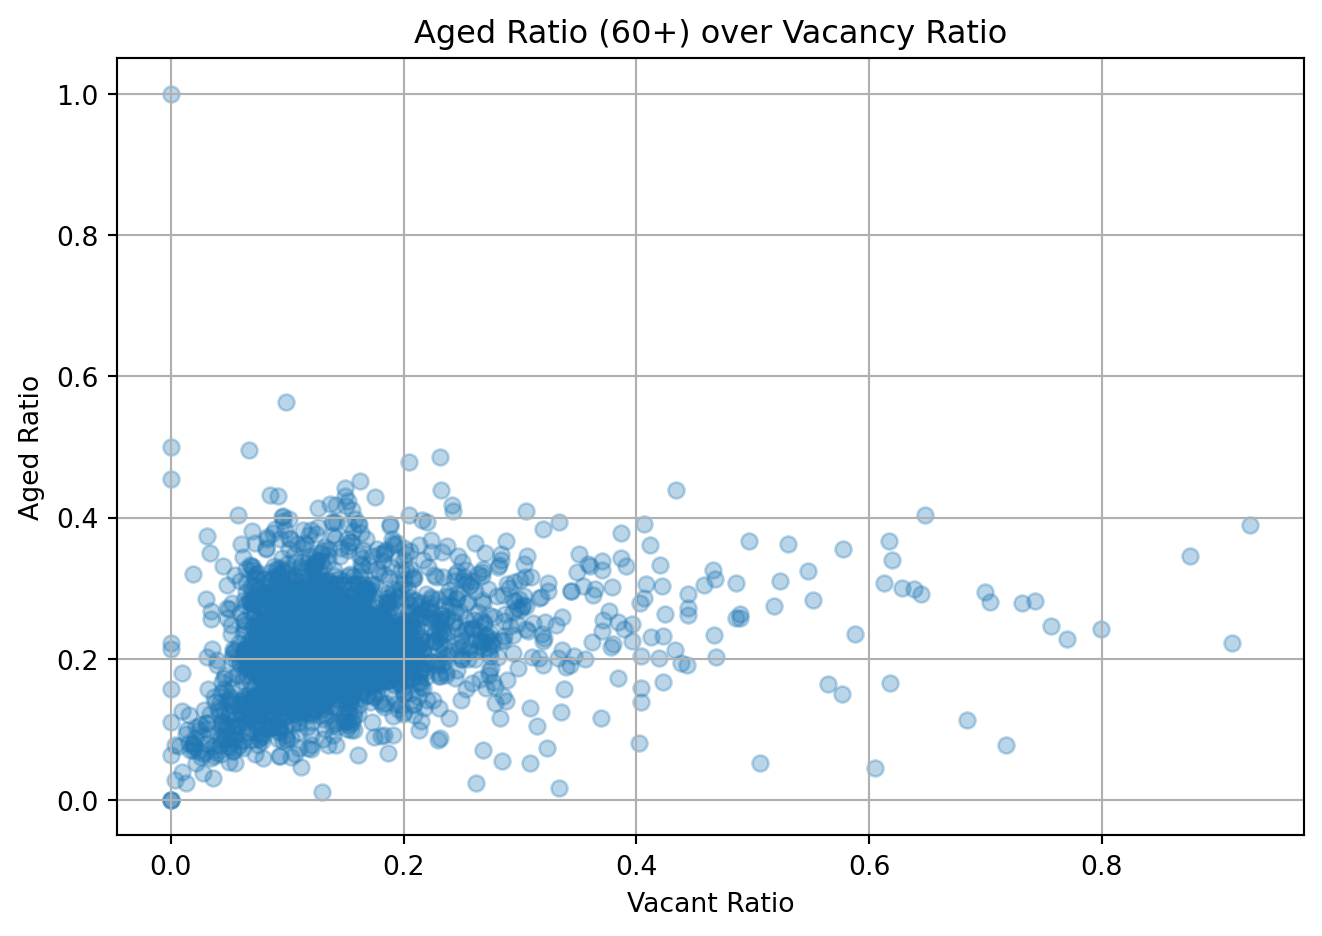

In [14]:
# Plot Aged Ratio vs. Vacant Ratio for 2010
plt.scatter(pr_df_2010["VacantRatio"], pr_df_2010["AgedRatio"], alpha=0.3)  # Transparent points

plt.title("Aged Ratio (60+) over Vacancy Ratio")  # Plot title
plt.xlabel("Vacant Ratio")  # X-axis label
plt.ylabel("Aged Ratio")  # Y-axis label
plt.grid(True)  # Show grid
plt.tight_layout()  # Adjust layout
plt.show()  # Display plot

This step prepares for comparison between the 2010 and 2020 datasets. 

It selects key columns (like total population, aged population, and vacancy) from the 2010 data and merges them with the full 2020 data using GISJOIN as a unique geographic identifier. 

The resulting merged_df contains side-by-side values for both years, using suffixes to distinguish 2010 and 2020 columns.

In [15]:
# Key columns to compare between years
columns_used = [
    "Total_Population",  "Pop60plus_total", "AgedRatio",
    "Total_Housing_Units", "Occupied", "Vacant", "VacantRatio"
]

# Merge 2020 data with selected 2010 columns using GISJOIN
merged_df = pr_df_2020.merge(
    pr_df_2010[["GISJOIN"] + columns_used],  # Keep GISJOIN + key columns from 2010
    on="GISJOIN",  # Join on geographic ID
    how="inner",  # Keep only matching rows
    suffixes=("_2020", "_2010")  # Label columns by year
)

# View merged dataset
merged_df

,GISJOIN,YEAR,STUSAB,GEOID,GEOCODE,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,...,Pop60plus_total_2020,AgedRatio_2020,VacantRatio_2020,Total_Population_2010,Pop60plus_total_2010,AgedRatio_2010,Total_Housing_Units_2010,Occupied_2010,Vacant_2010,VacantRatio_2010
0,G72000109563001,2020,PR,1500000US720019563001,720019563001,9,0,Puerto Rico,72,Adjuntas Municipio,...,562,0.298301,0.102815,2171,363,0.167204,854,737,117,0.137002
1,G72000109563002,2020,PR,1500000US720019563002,720019563002,9,0,Puerto Rico,72,Adjuntas Municipio,...,568,0.286290,0.070263,2165,438,0.202309,881,751,130,0.147560
2,G72000109564001,2020,PR,1500000US720019564001,720019564001,9,0,Puerto Rico,72,Adjuntas Municipio,...,483,0.295956,0.103064,1852,322,0.173866,801,677,124,0.154806
3,G72000109564002,2020,PR,1500000US720019564002,720019564002,9,0,Puerto Rico,72,Adjuntas Municipio,...,370,0.365252,0.092593,1143,277,0.242345,493,418,75,0.152130
4,G72000109565001,2020,PR,1500000US720019565001,720019565001,9,0,Puerto Rico,72,Adjuntas Municipio,...,523,0.278191,0.138142,2100,346,0.164762,827,682,145,0.175333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2244,G72015307506011,2020,PR,1500000US721537506011,721537506011,9,0,Puerto Rico,72,Yauco Municipio,...,487,0.243988,0.167658,1335,298,0.223221,565,475,90,0.159292
2245,G72015307506012,2020,PR,1500000US721537506012,721537506012,9,0,Puerto Rico,72,Yauco Municipio,...,284,0.294912,0.083146,2986,481,0.161085,1201,1058,143,0.119067
2246,G72015307506013,2020,PR,1500000US721537506013,721537506013,9,0,Puerto Rico,72,Yauco Municipio,...,360,0.255500,0.184638,994,69,0.069416,340,322,18,0.052941
2247,G72015307506021,2020,PR,1500000US721537506021,721537506021,9,0,Puerto Rico,72,Yauco Municipio,...,481,0.353937,0.221906,1872,436,0.232906,813,681,132,0.162362


## Comparing Time Series 

To understand demographic and housing trends over time, we compare key indicators from different time periods. By calculating the absolute changes we can assess patterns of population decline, aging, and housing dynamics at the local level.

This step calculates absolute changes between 2010 and 2020 for several key indicators: total population, population aged 60+, vacant housing units, and the ratios of aged population and vacancy. These new columns will help identify trends across geographic areas. Missing values in the AgedRatio_Change column are filled with 0 to ensure clean outputs.


In [16]:
# Calculate absolute changes between 2010 and 2020
merged_df["Total_Pop_Change"] = merged_df["Total_Population_2020"] - merged_df["Total_Population_2010"]  # Change in total population
merged_df["Pop60plus_Change"] = merged_df["Pop60plus_total_2020"] - merged_df["Pop60plus_total_2010"]  # Change in 60+ population
merged_df["Vacant_Change"] = merged_df["Vacant_2020"] - merged_df["Vacant_2010"]  # Change in vacant units
merged_df["AgedRatio_Change"] = merged_df["AgedRatio_2020"] - merged_df["AgedRatio_2010"]  # Change in aged ratio
merged_df["AgedRatio_Change"].fillna(0, inplace=True)  # Fill missing with 0
merged_df["VacantRatio_Change"] = merged_df["VacantRatio_2020"] - merged_df["VacantRatio_2010"]  # Change in vacancy ratio

# View updated DataFrame
merged_df


C:\Users\jmartine\AppData\Local\Temp\6\ipykernel_22600\1793893454.py:6: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,GISJOIN,YEAR,STUSAB,GEOID,GEOCODE,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,...,AgedRatio_2010,Total_Housing_Units_2010,Occupied_2010,Vacant_2010,VacantRatio_2010,Total_Pop_Change,Pop60plus_Change,Vacant_Change,AgedRatio_Change,VacantRatio_Change
0,G72000109563001,2020,PR,1500000US720019563001,720019563001,9,0,Puerto Rico,72,Adjuntas Municipio,...,0.167204,854,737,117,0.137002,-287,199,-33,0.131097,-0.034187
1,G72000109563002,2020,PR,1500000US720019563002,720019563002,9,0,Puerto Rico,72,Adjuntas Municipio,...,0.202309,881,751,130,0.147560,-181,130,-74,0.083981,-0.077296
2,G72000109564001,2020,PR,1500000US720019564001,720019564001,9,0,Puerto Rico,72,Adjuntas Municipio,...,0.173866,801,677,124,0.154806,-220,161,-50,0.122090,-0.051742
3,G72000109564002,2020,PR,1500000US720019564002,720019564002,9,0,Puerto Rico,72,Adjuntas Municipio,...,0.242345,493,418,75,0.152130,-130,93,-35,0.122907,-0.059537
4,G72000109565001,2020,PR,1500000US720019565001,720019565001,9,0,Puerto Rico,72,Adjuntas Municipio,...,0.164762,827,682,145,0.175333,-220,177,-32,0.113430,-0.037191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2244,G72015307506011,2020,PR,1500000US721537506011,721537506011,9,0,Puerto Rico,72,Yauco Municipio,...,0.223221,565,475,90,0.159292,661,189,51,0.020767,0.008366
2245,G72015307506012,2020,PR,1500000US721537506012,721537506012,9,0,Puerto Rico,72,Yauco Municipio,...,0.161085,1201,1058,143,0.119067,-2023,-197,-106,0.133827,-0.035921
2246,G72015307506013,2020,PR,1500000US721537506013,721537506013,9,0,Puerto Rico,72,Yauco Municipio,...,0.069416,340,322,18,0.052941,415,291,107,0.186084,0.131697
2247,G72015307506021,2020,PR,1500000US721537506021,721537506021,9,0,Puerto Rico,72,Yauco Municipio,...,0.232906,813,681,132,0.162362,-513,45,24,0.121031,0.059544


# Plotting Graphs from IPUMS data:

This visualization step uses a `Seaborn pairplot` to explore the relationships between key change variables from 2010 to 2020. 

By plotting scatterplots for every pair of variables and histograms along the diagonal we can quickly spot correlations or patterns in population decline, aging, and housing vacancy across Puerto Rico’s geographic units.


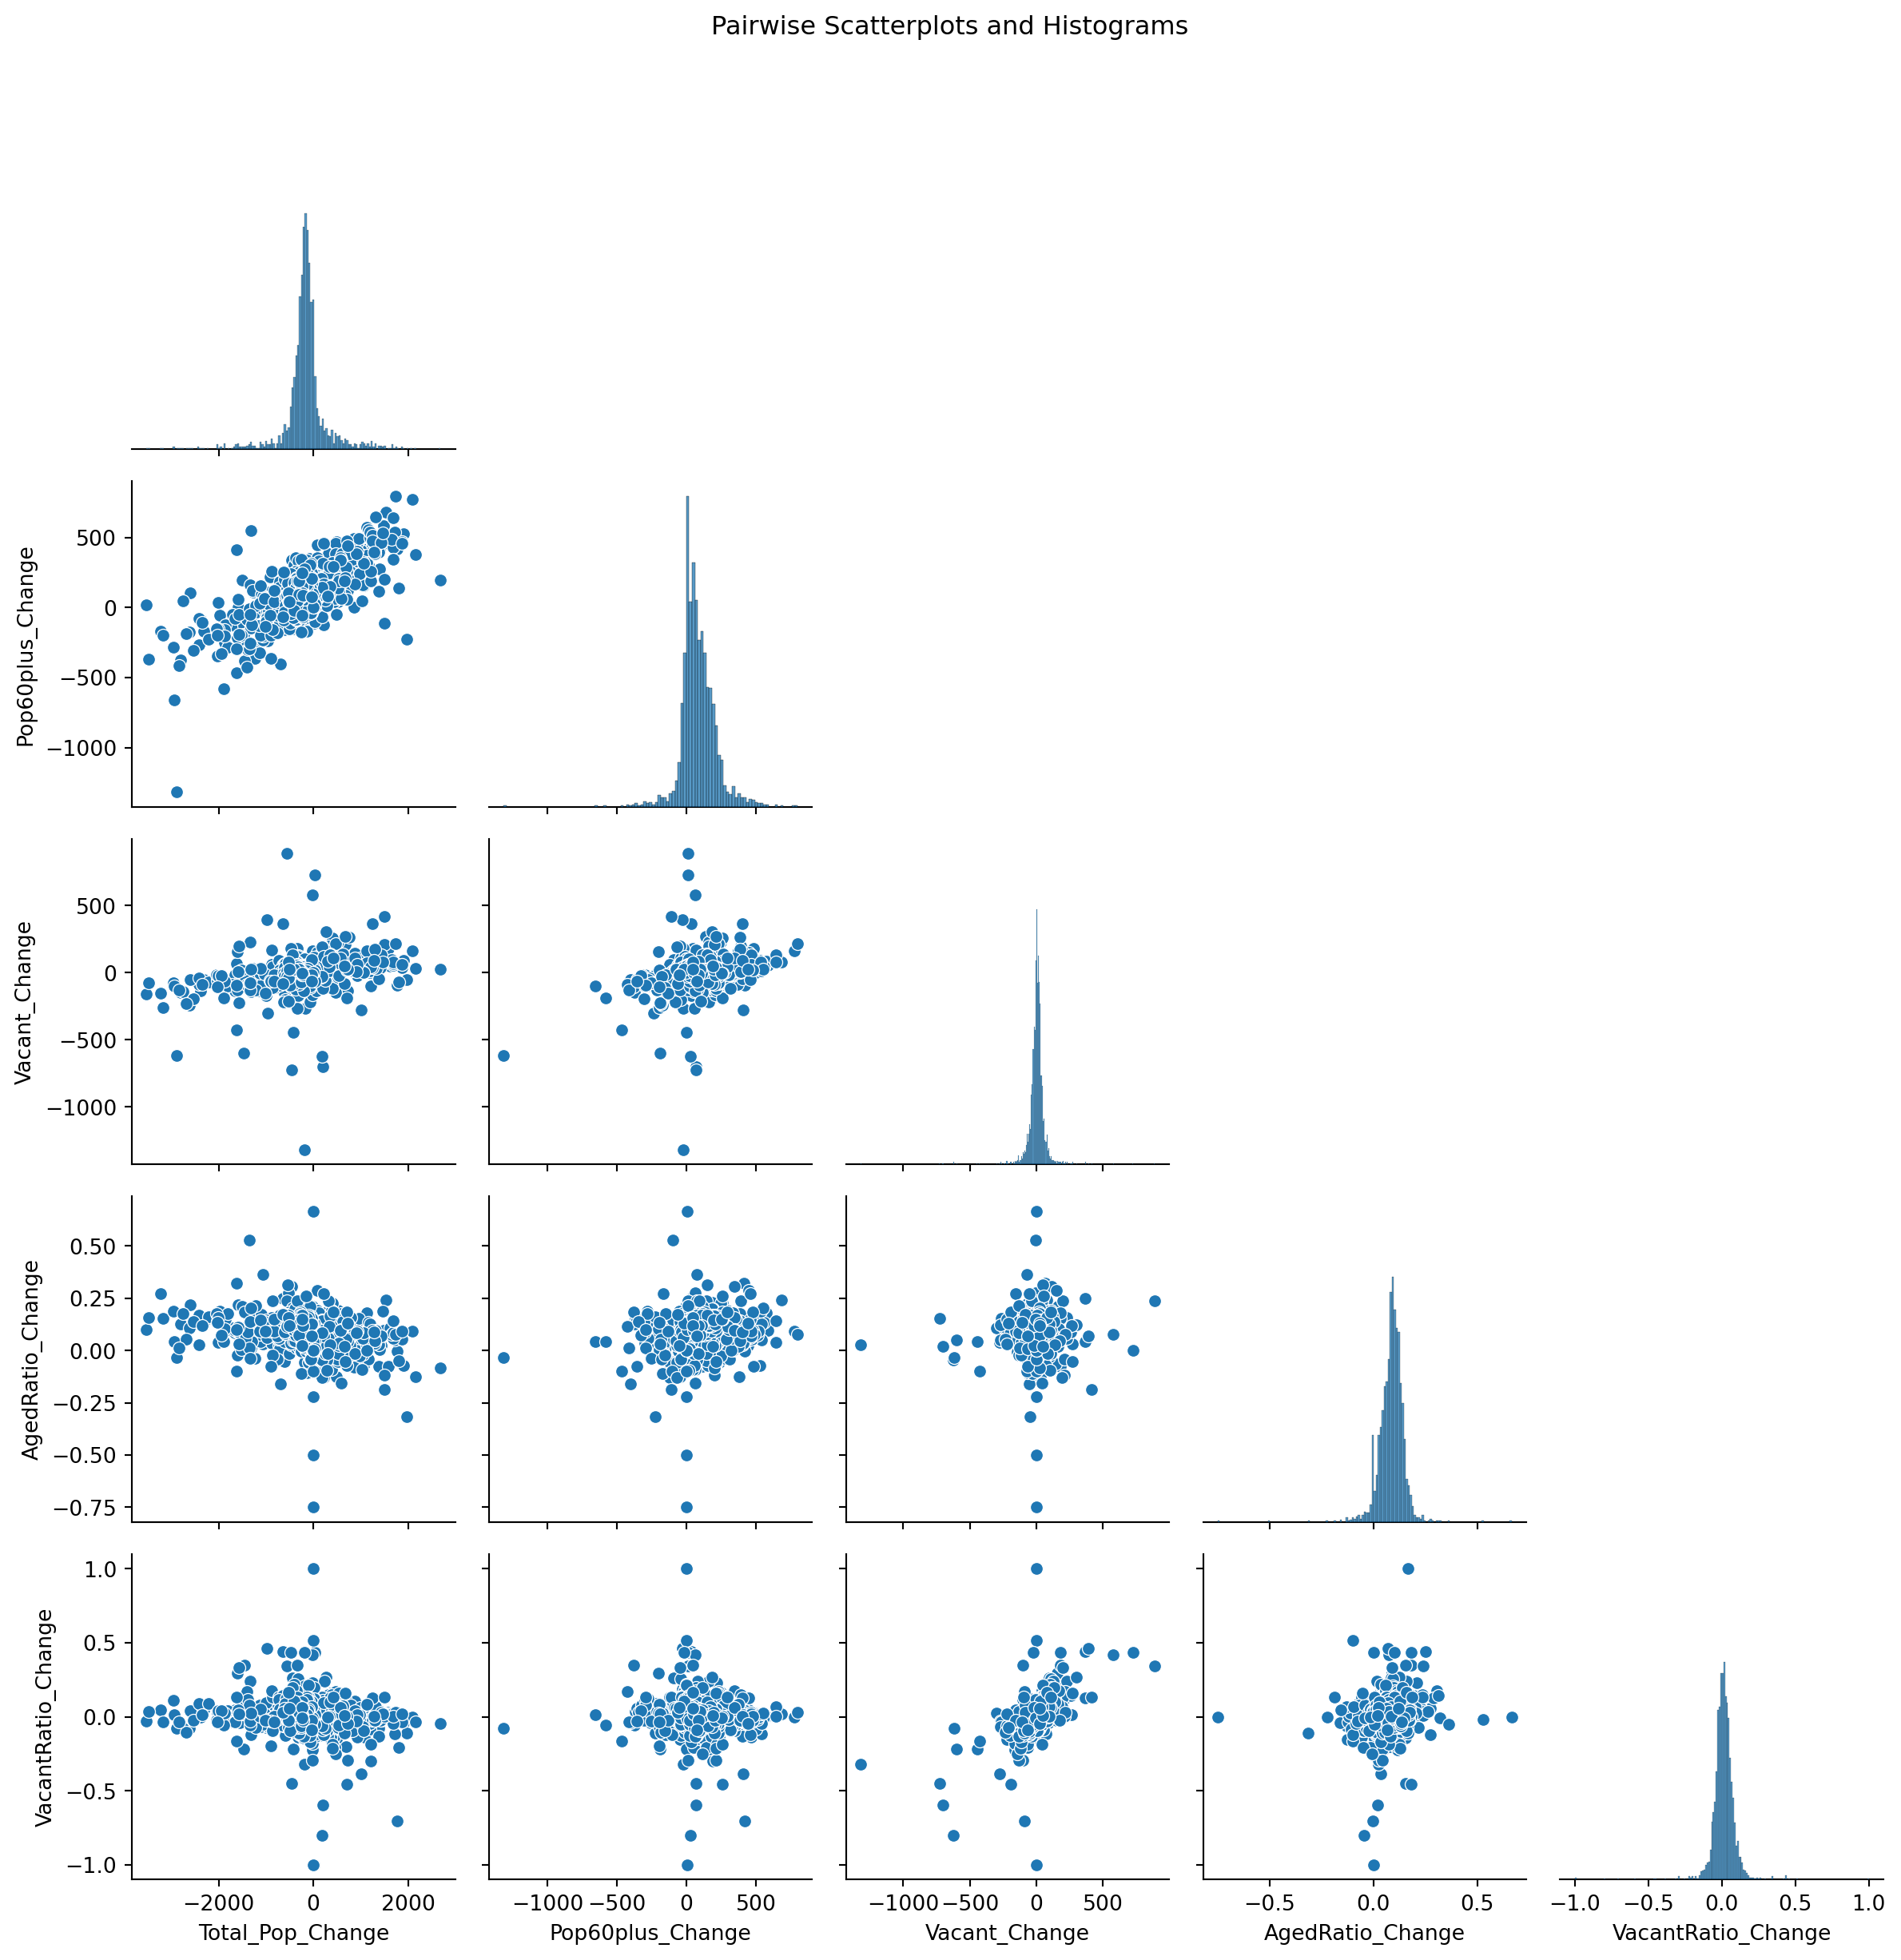

In [17]:
# Choose key variables to compare
vars_to_plot = [
    "Total_Pop_Change",
    "Pop60plus_Change",
    "Vacant_Change",
    "AgedRatio_Change",
    "VacantRatio_Change"
]

# Subset DataFrame to those variables
data_subset = merged_df[vars_to_plot]

# Create pairwise plots with histograms on the diagonal
sns.pairplot(data_subset, diag_kind="hist", corner=True)

plt.suptitle("Pairwise Scatterplots and Histograms", y=1.02)  # Set overall title
plt.tight_layout()
plt.show()  # Display the plot


This histogram shows the distribution of changes in the number of vacant housing units from 2010 to 2020 across Puerto Rico. 

It helps identify whether most areas experienced increases or decreases in vacancy—and how large those shifts were.


Text(0.5, 1.0, 'Vacancy Ratio Change 2010-2020')

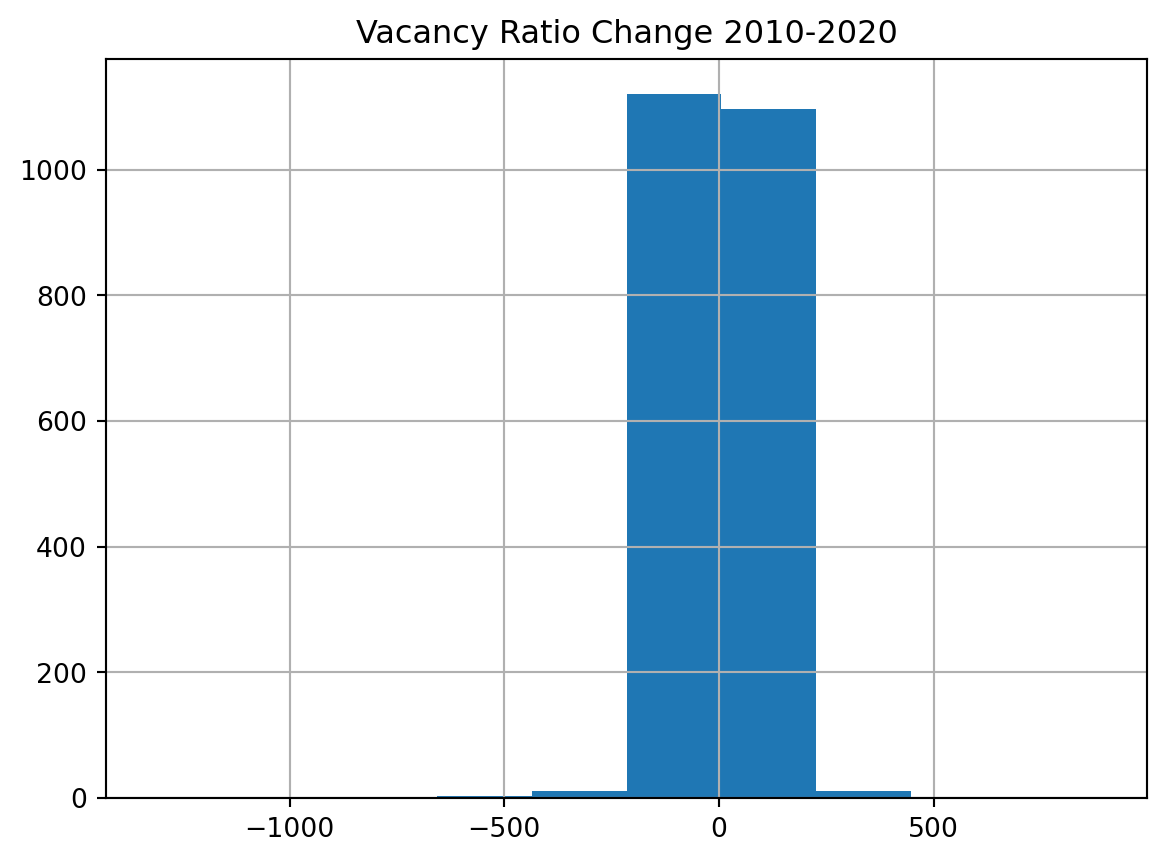

In [18]:
merged_df["Vacant_Change"] .hist()

plt.title("Vacancy Ratio Change 2010-2020")

By looking more closely at the histogram and comparing vacancy differences between 2010 and 2020, it becomes evident that quantile-based classification may not accurately reflect true differences across areas. In cases with extreme outliers, quantile breaks can distort interpretation.

To better evaluate how unusual each area's change is, we compute z-scores for each variable. This standardizes the values by subtracting the mean and dividing by the standard deviation, allowing for comparisons across indicators on a consistent scale.


::: {.callout-tip style="color: #5a7a2b;"}

## Math Refresher

A z-score tells us how many standard deviations a value is from the mean. A positive z-score means the value is above the mean. A negative z-score means it's below the mean. Z-scores help us compare variables on different scales and identify outliers—typically anything above +2 or below –2 is considered unusually high or low.

:::


In [19]:
# Compute means and standard deviations
means = merged_df[vars_to_plot].mean()
stds = merged_df[vars_to_plot].std()

# Create z-score columns
for var in vars_to_plot:
    z_col = var.replace("_Change", "_dz")
    merged_df[z_col] = (merged_df[var] - means[var]) / stds[var]

This histogram displays the z-score distribution of vacant housing unit change from 2010 to 2020. Standardizing vacancy change in this way helps identify how extreme the change in each area is compared to the average:

Text(0.5, 1.0, 'Male/Female Ratio Total Change 2010-2020 (In thousands) Z-score')

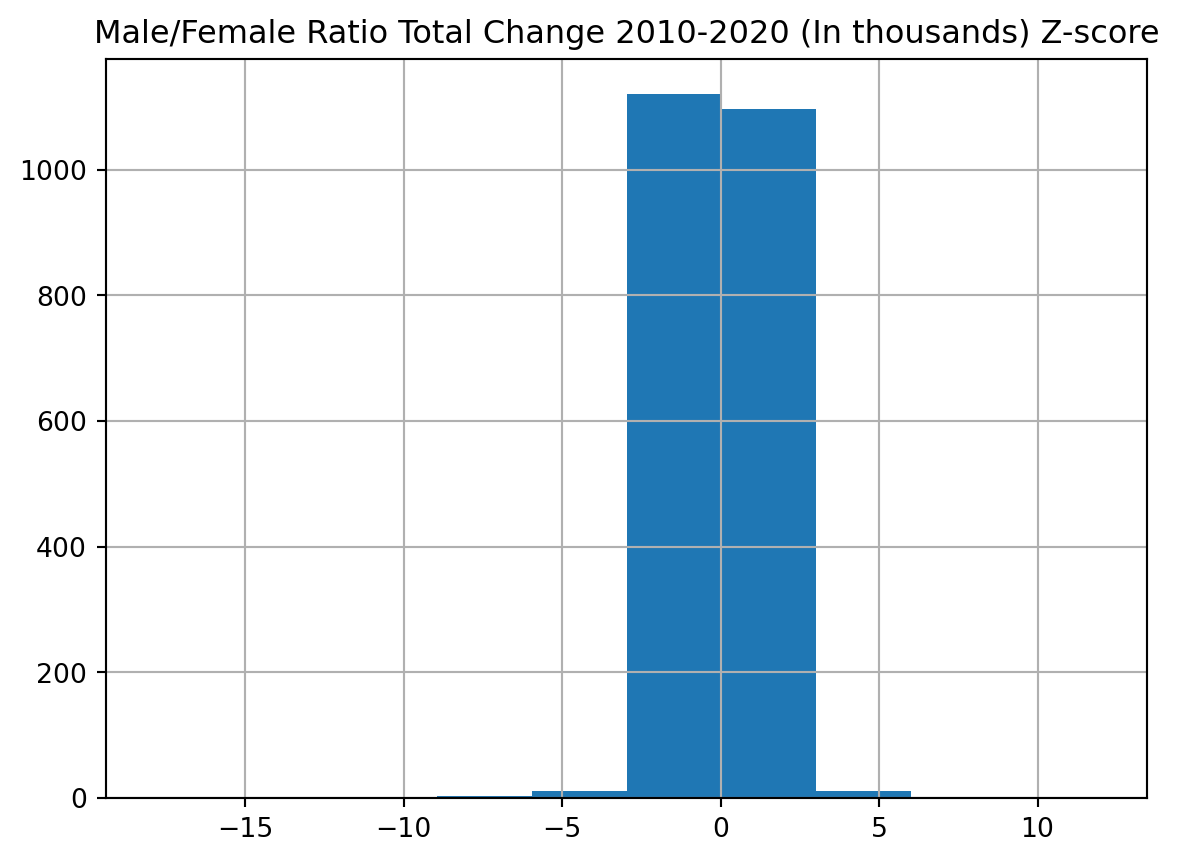

In [20]:
merged_df["Vacant_dz"] .hist()

plt.title("Male/Female Ratio Total Change 2010-2020 (In thousands) Z-score")

This `pairplot` function uses the z-score standardized versions of the change variables to compare their relative behavior across Block Groups in a **scatterplot matrix**. 

By putting all variables on the same scale (mean = 0, std = 1), we can asily spot strong linear relationships, identify clusters or outliers, and ompare change intensity across different domains (e.g., aging vs. vacancy).

This is especially useful when your original variables had different units or ranges.


Can you spot any linear trends in the scatterplots?

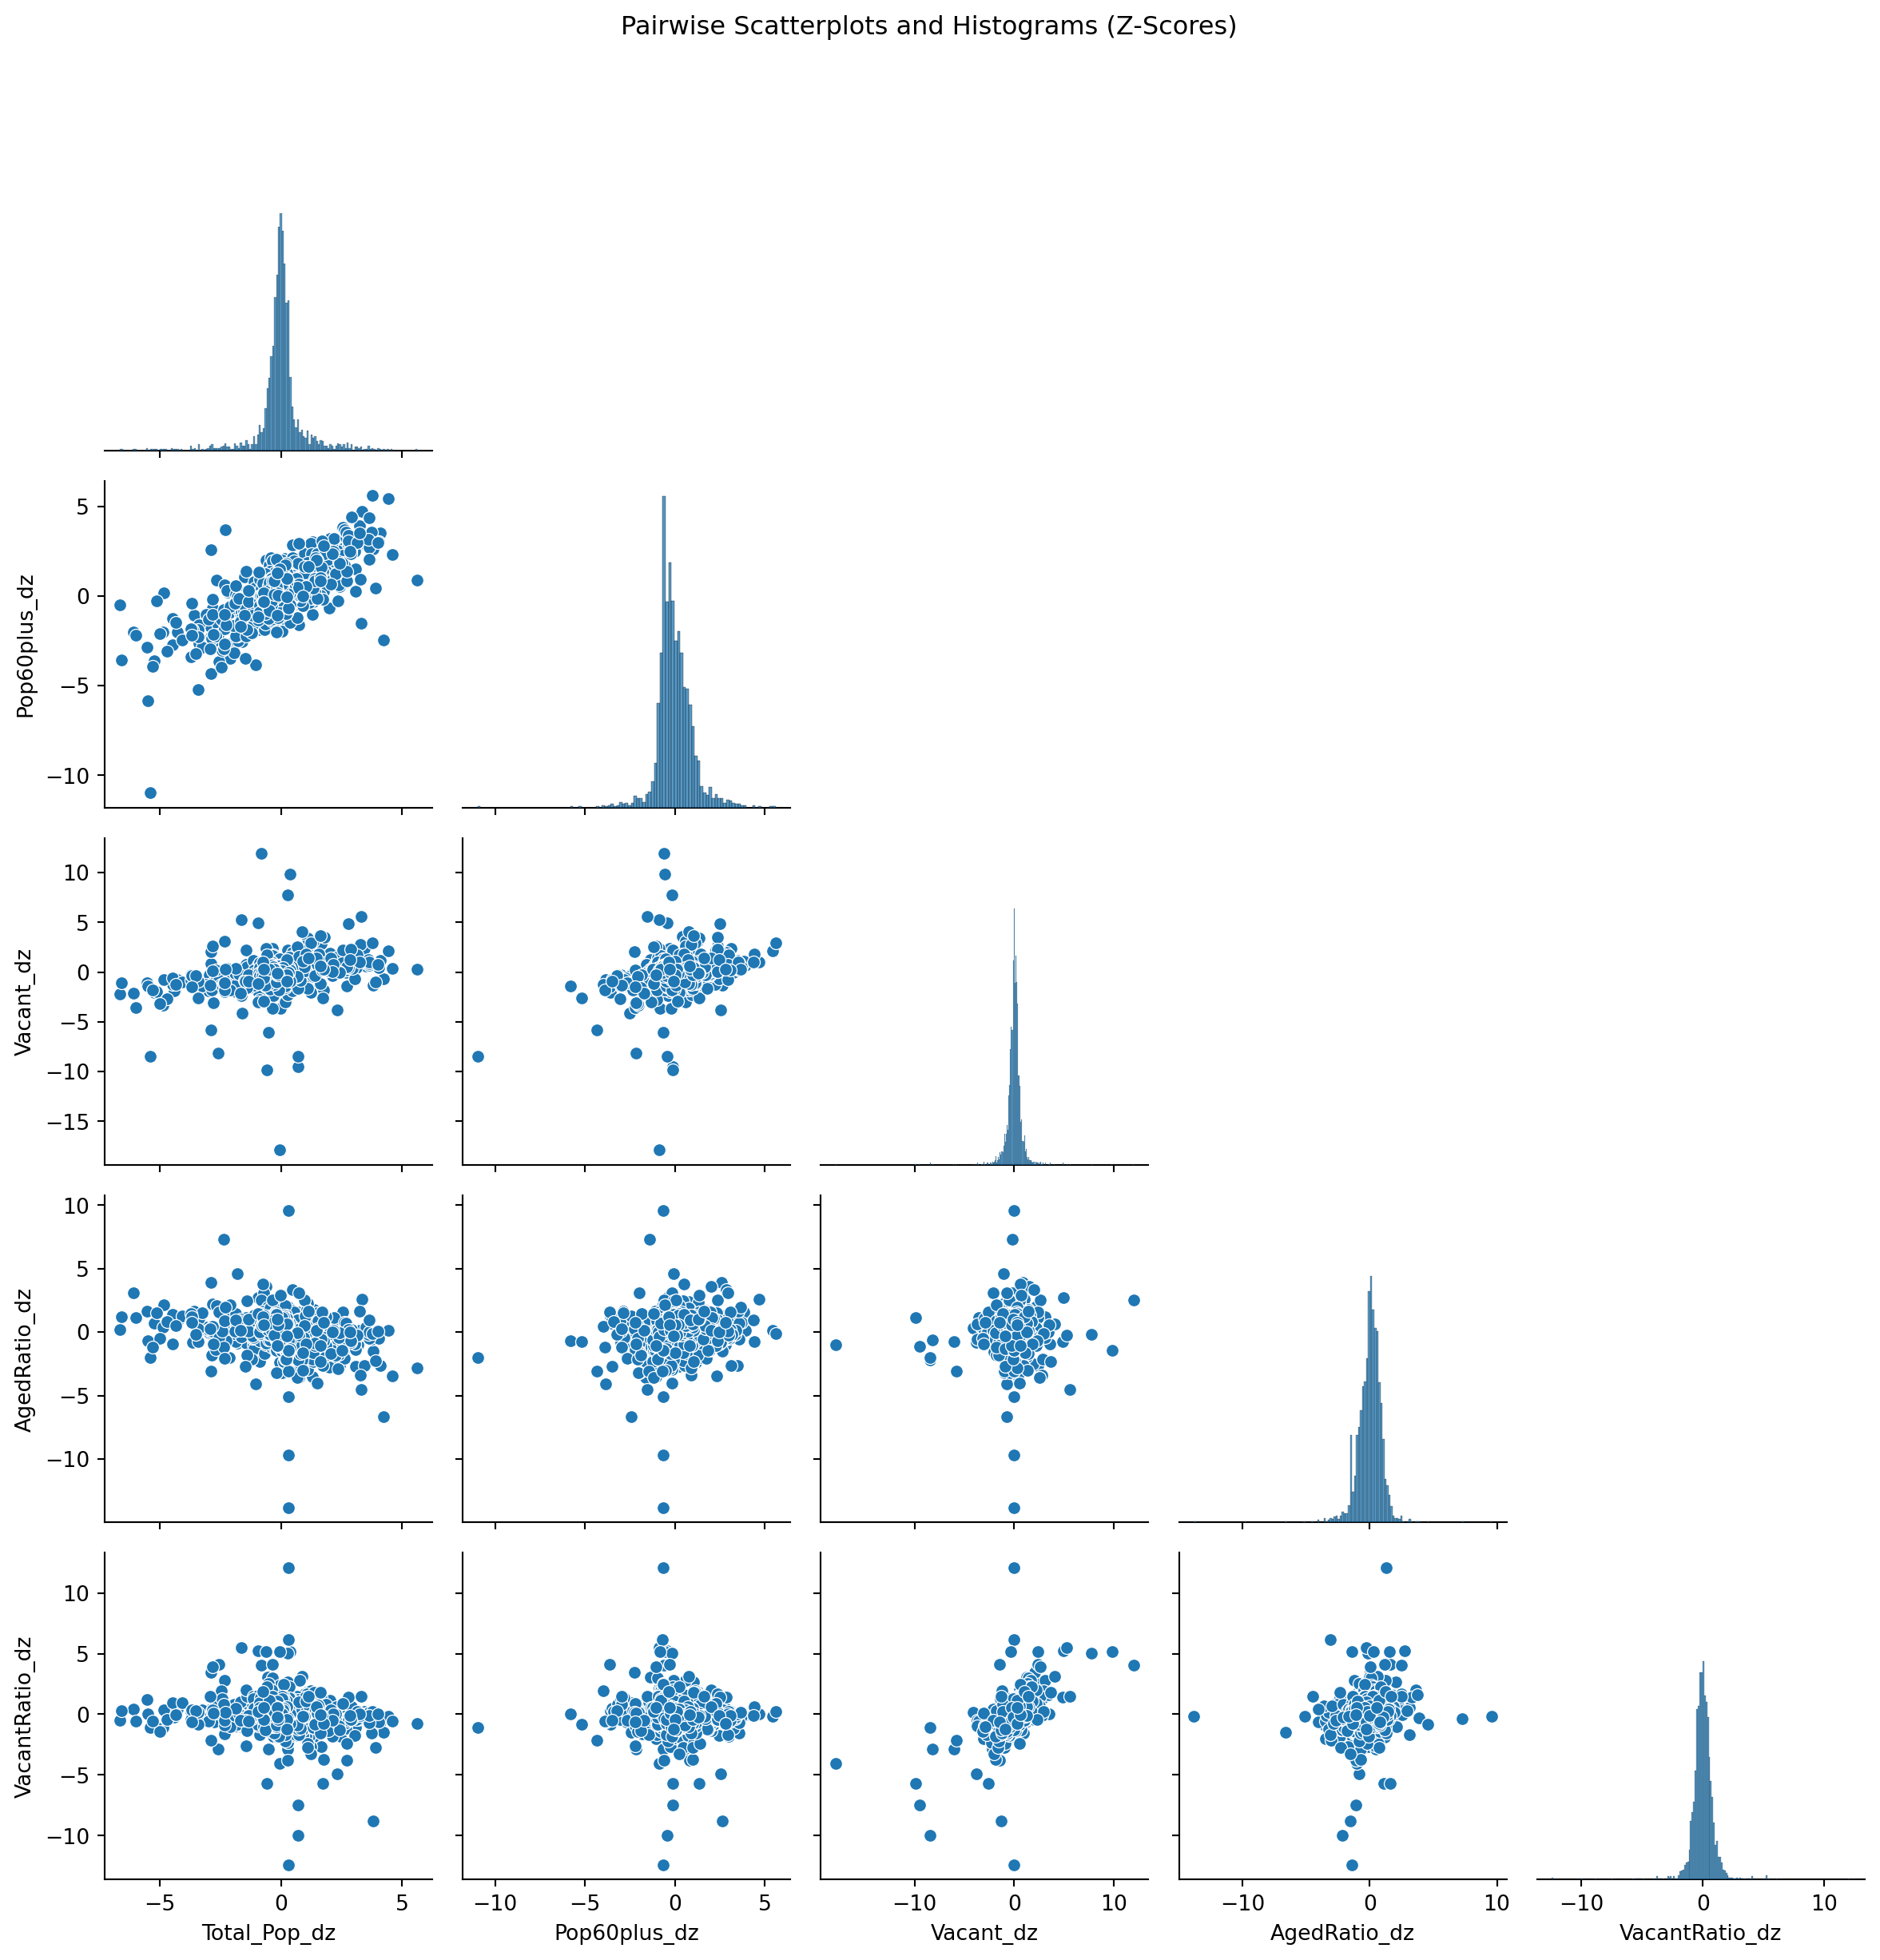

In [21]:
#
# Select all z-score columns (those ending in "_dz")
zscore_cols = [col for col in merged_df.columns if col.endswith("_dz")]
data_subset = merged_df[zscore_cols]  # Subset for plotting

# Create pairplot of standardized change variables
sns.pairplot(data_subset, diag_kind="hist", corner=True)  # No duplicate plots, hist on diagonal

plt.suptitle("Pairwise Scatterplots and Histograms (Z-Scores)", y=1.02)  # Title above plot
plt.tight_layout()
plt.show()  # Display the plot


This scatterplot shows the relationship between changes in vacancy rates and aging ratios (ages 60+) using their z-scores, allowing for meaningful comparison on a standardized scale for the two variables.

This type of scaling:

- Keeps the area near zero linear (for interpretability)

- Compresses extreme values

- Handles both positive and negative changes symmetrically.

This visualization helps identify whether increases in older populations are associated with changes in housing vacancy—and how extreme those shifts are across Puerto Rico.


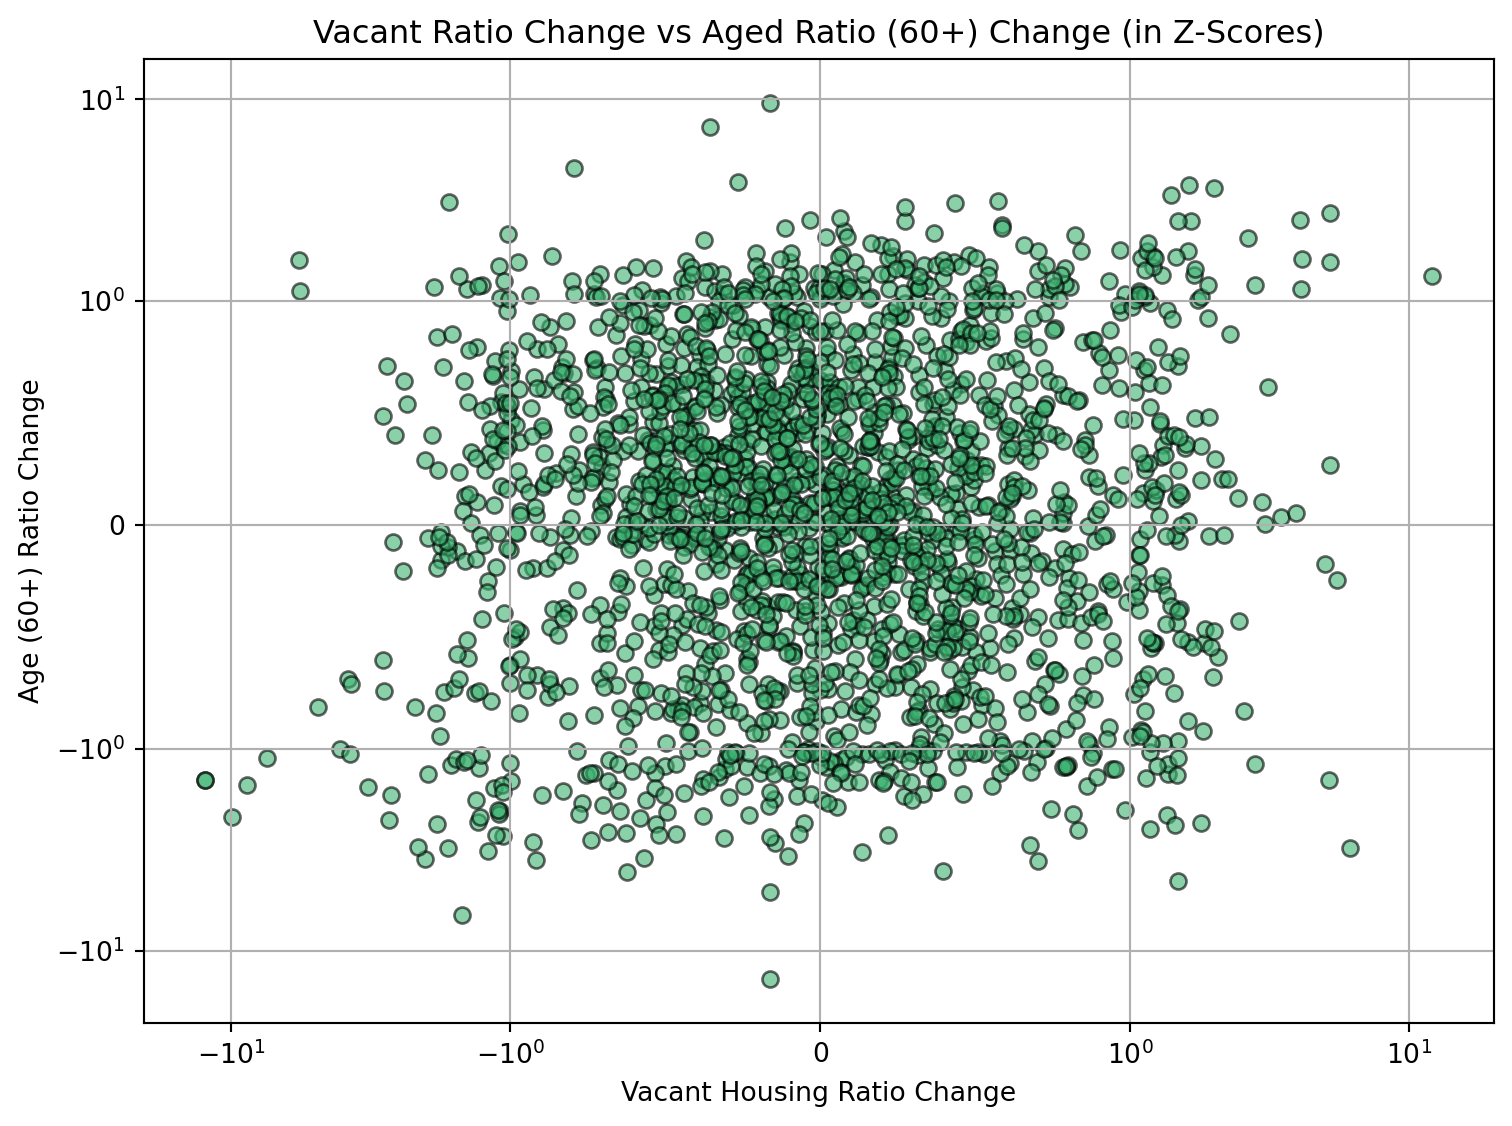

In [22]:
# Create a scatter plot of z-score changes
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(
    merged_df["VacantRatio_dz"],  # X-axis: vacancy ratio z-score
    merged_df["AgedRatio_dz"],    # Y-axis: aging ratio z-score
    alpha=0.6,
    color="mediumseagreen",
    edgecolor="black"
)

# Apply symmetric log scaling to both axes
ax.set_xscale("symlog", linthresh=1)  # Linear near 0, log beyond ±1
ax.set_yscale("symlog", linthresh=1)

# Add labels and title
ax.set_xlabel("Vacant Housing Ratio Change")  # X-axis label
ax.set_ylabel("Age (60+) Ratio Change")       # Y-axis label
ax.set_title("Vacant Ratio Change vs Aged Ratio (60+) Change (in Z-Scores)")

# Grid and layout
ax.grid(True)
plt.tight_layout()
plt.show()


## Generating Age Pyramids

Another useful way to analyze popylation is with population pyramids for Puerto Rico using mean percentages of male and female population by age group, based on census block-level data. The pyramid compares the age structure visually between sexes, helping identify trends like population aging or gender imbalances in specific cohorts.

Key Steps in the Code:

First, Extract age-by-sex columns from the dataset.


In [23]:
# Define the relevant columns
joined_columns = [col for col in merged_df.columns if col.startswith("Male:") or col.startswith("Female:")]

# Create DataFrame for percentage values
pct_df = merged_df[["Total_Population_2020"] + joined_columns].copy()

Convert raw population counts into percentage values by age group, making them easier to compare across geographic units regardless of their total population size. Then, it separates the age group columns into male and female categories to prepare for a population pyramid:


In [24]:
# 4. Compute percentage for each age group column
for col in joined_columns:
    pct_df[f"{col}_pct"] = pct_df[col] / pct_df["Total_Population_2020"] * 100

# 5. Drop original count columns, keep only percent columns
pct_df = pct_df[[col for col in pct_df.columns if col.endswith("_pct")]]

# 6. Separate by sex
male_age_percentages = []
female_age_percentages = []

This following part calculates the average percent of total population for each age group, separately for males and females, across all geographic units (e.g., blocks).

It also creates a clean DataFrame that aligns age group labels with their corresponding male and female percentages, setting the foundation for the population pyramid.


In [25]:
for col in pct_df.columns:
    mean_pct = round(pct_df[col].mean(), 2)
    if col.startswith("Male:"):
        male_age_percentages.append(mean_pct)
    elif col.startswith("Female:"):
        female_age_percentages.append(mean_pct)

# 7. Extract age labels
new_age_columns = [col.split(": ")[1].replace("_pct", "") for col in pct_df.columns if col.startswith("Male:")]

# 8. Create the base DataFrame
population_df = pd.DataFrame({
    "Age": new_age_columns,
    "Male": male_age_percentages,
    "Female": female_age_percentages
})
population = population_df.copy()

We can cambine narrow age bands into broader, more interpretable age groups (like 15–19 or 20–24) to improve the readability of the population pyramid. 

In the plot, we manually add percentages for adjacent rows as the age group label.

After combining, it prepares the data for bidirectional horizontal bar plotting by making male values negative (so they show on the left), keeping female values positive (on the right), and creating helper columns for width and placement of bars.


In [26]:
# Combine select age groups
# Combine 15-17 and 18-19 into 15-19
population.iloc[3, 0] = "15 to 19 years"
population.iloc[3, 1] += population.iloc[4, 1]
population.iloc[3, 2] += population.iloc[4, 2]
population = population.drop(index=4).reset_index(drop=True)

# Combine 20, 21, 22–24 into 20–24
population.iloc[4, 0] = "20 to 24 years"
population.iloc[4, 1] += population.iloc[5, 1] + population.iloc[6, 1]
population.iloc[4, 2] += population.iloc[5, 2] + population.iloc[6, 2]
population = population.drop(index=[5, 6]).reset_index(drop=True)

# Combine 60–61 and 62–64 into 60–64
population.iloc[12, 0] = "60 to 64 years"
population.iloc[12, 1] += population.iloc[13, 1]
population.iloc[12, 2] += population.iloc[13, 2]
population = population.drop(index=13).reset_index(drop=True)

# Combine 65–66 and 67–69 into 65–69
population.iloc[13, 0] = "65 to 69 years"
population.iloc[13, 1] += population.iloc[14, 1]
population.iloc[13, 2] += population.iloc[14, 2]
population = population.drop(index=14).reset_index(drop=True)

# Prepare for plotting
population["Female_Left"] = 0
population["Female_Width"] = population["Female"]
population["Male_Left"] = -population["Male"]
population["Male_Width"] = population["Male"]

# Round for labels
population["Male"] = population["Male"].round(2)
population["Female"] = population["Female"].round(2)

The horizontal population pyramid displays the average percent of Puerto Rico’s population in each age group, broken down by sex. Male bars extend left using negative values while Female bars extend right using positive values.

A custom title, axis formatting, and color scheme are applied for clarity and polish.

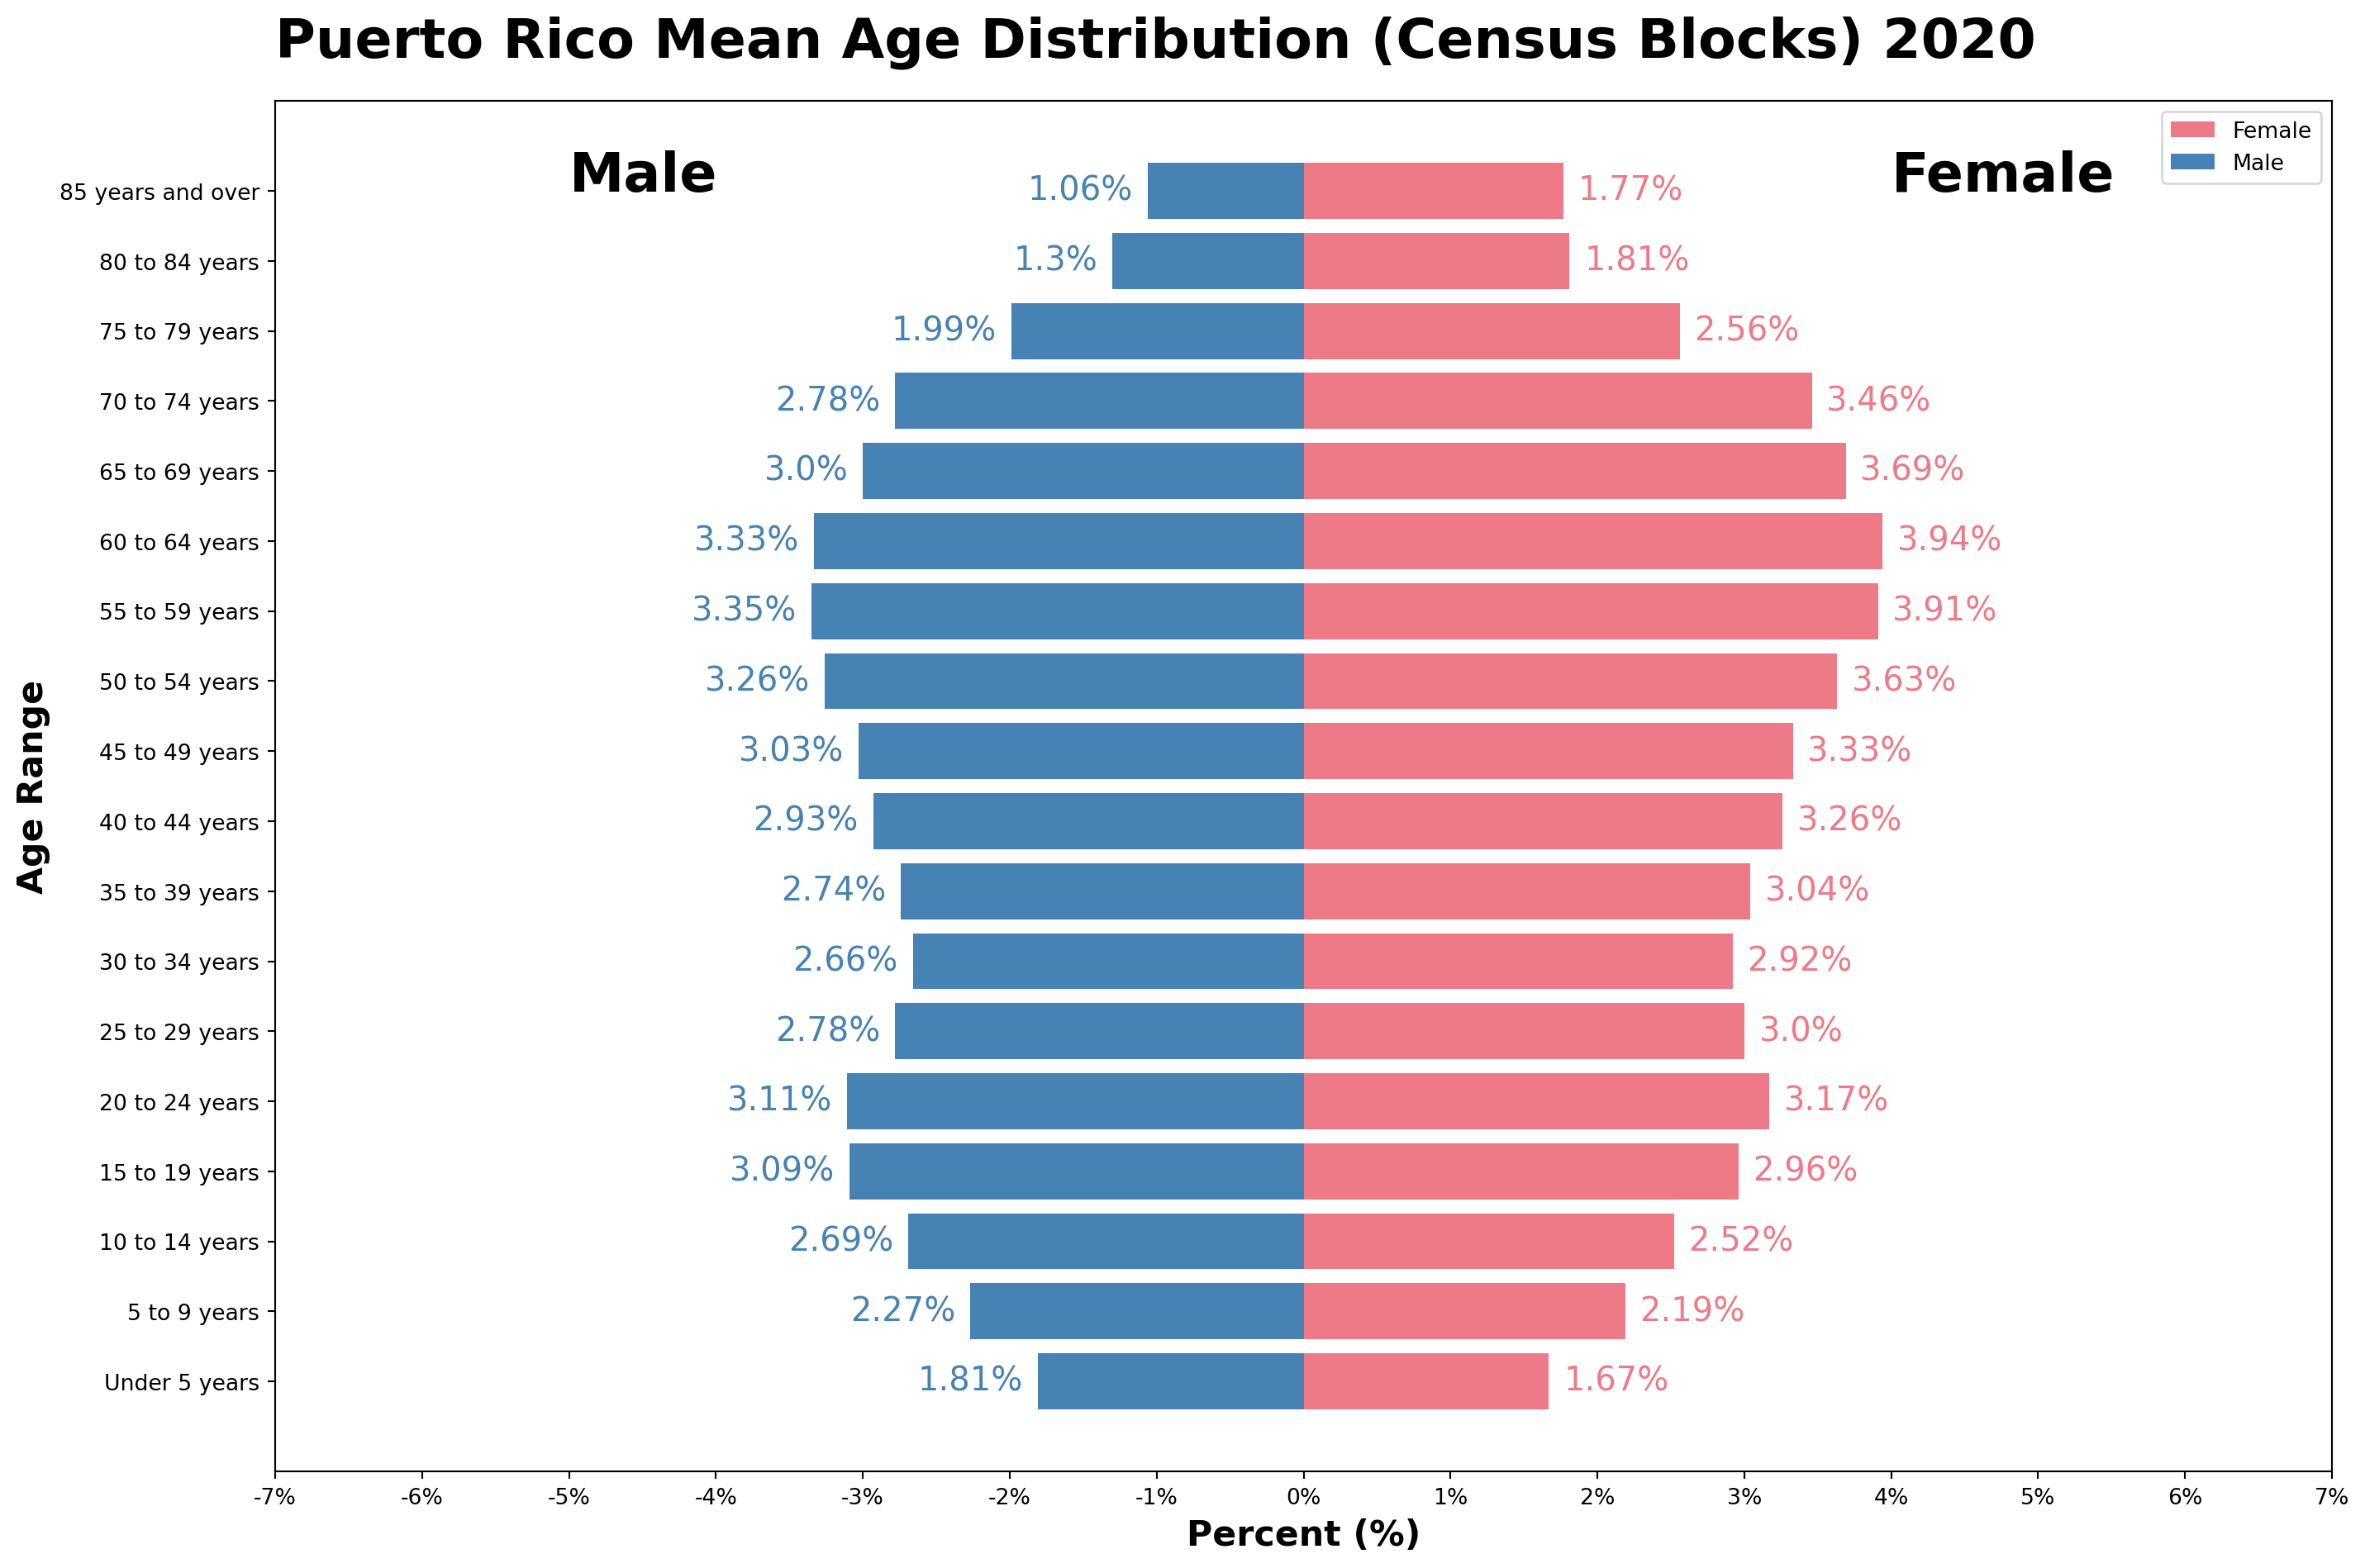

In [27]:
# 11. Plot the population pyramid
fig = plt.figure(figsize=(15, 10))  # Set figure size

# Plot female bars to the right
plt.barh(
    y=population["Age"],
    width=population["Female_Width"],
    color="#ee7a87",
    label="Female"
)

# Plot male bars to the left
plt.barh(
    y=population["Age"],
    width=population["Male_Width"],
    left=population["Male_Left"],
    color="#4682b4",
    label="Male"
)

# Add gender labels to plot
plt.text(-5, len(population) - 1, "Male", fontsize=25, fontweight="bold")
plt.text(4, len(population) - 1, "Female", fontsize=25, fontweight="bold")

# Add percentage labels to each bar
for idx in range(len(population)):
    # Male label (on the left)
    plt.text(
        x=population["Male_Left"][idx] - 0.1,
        y=idx,
        s="{}%".format(population["Male"][idx]),
        ha="right", va="center",
        fontsize=15, color="#4682b4"
    )
    # Female label (on the right)
    plt.text(
        x=population["Female_Width"][idx] + 0.1,
        y=idx,
        s="{}%".format(population["Female"][idx]),
        ha="left", va="center",
        fontsize=15, color="#ee7a87"
    )

# Format axes and labels
plt.xlim(-7, 7)  # Set x-axis limits
plt.xticks(range(-7, 8), ["{}%".format(i) for i in range(-7, 8)])  # Format tick labels as percents
plt.legend(loc="best")  # Add legend
plt.xlabel("Percent (%)", fontsize=16, fontweight="bold")
plt.ylabel("Age Range", fontsize=16, fontweight="bold")

# Add title
plt.title(
    "Puerto Rico Mean Age Distribution (Census Blocks) 2020",
    loc="left", pad=20,
    fontsize=25, fontweight="bold"
)

plt.tight_layout()  # Optimize spacing
plt.show()  # Display the plot


### Select an individual census block

We can subset the dataframe to select a single census block and generate an age pyramid.


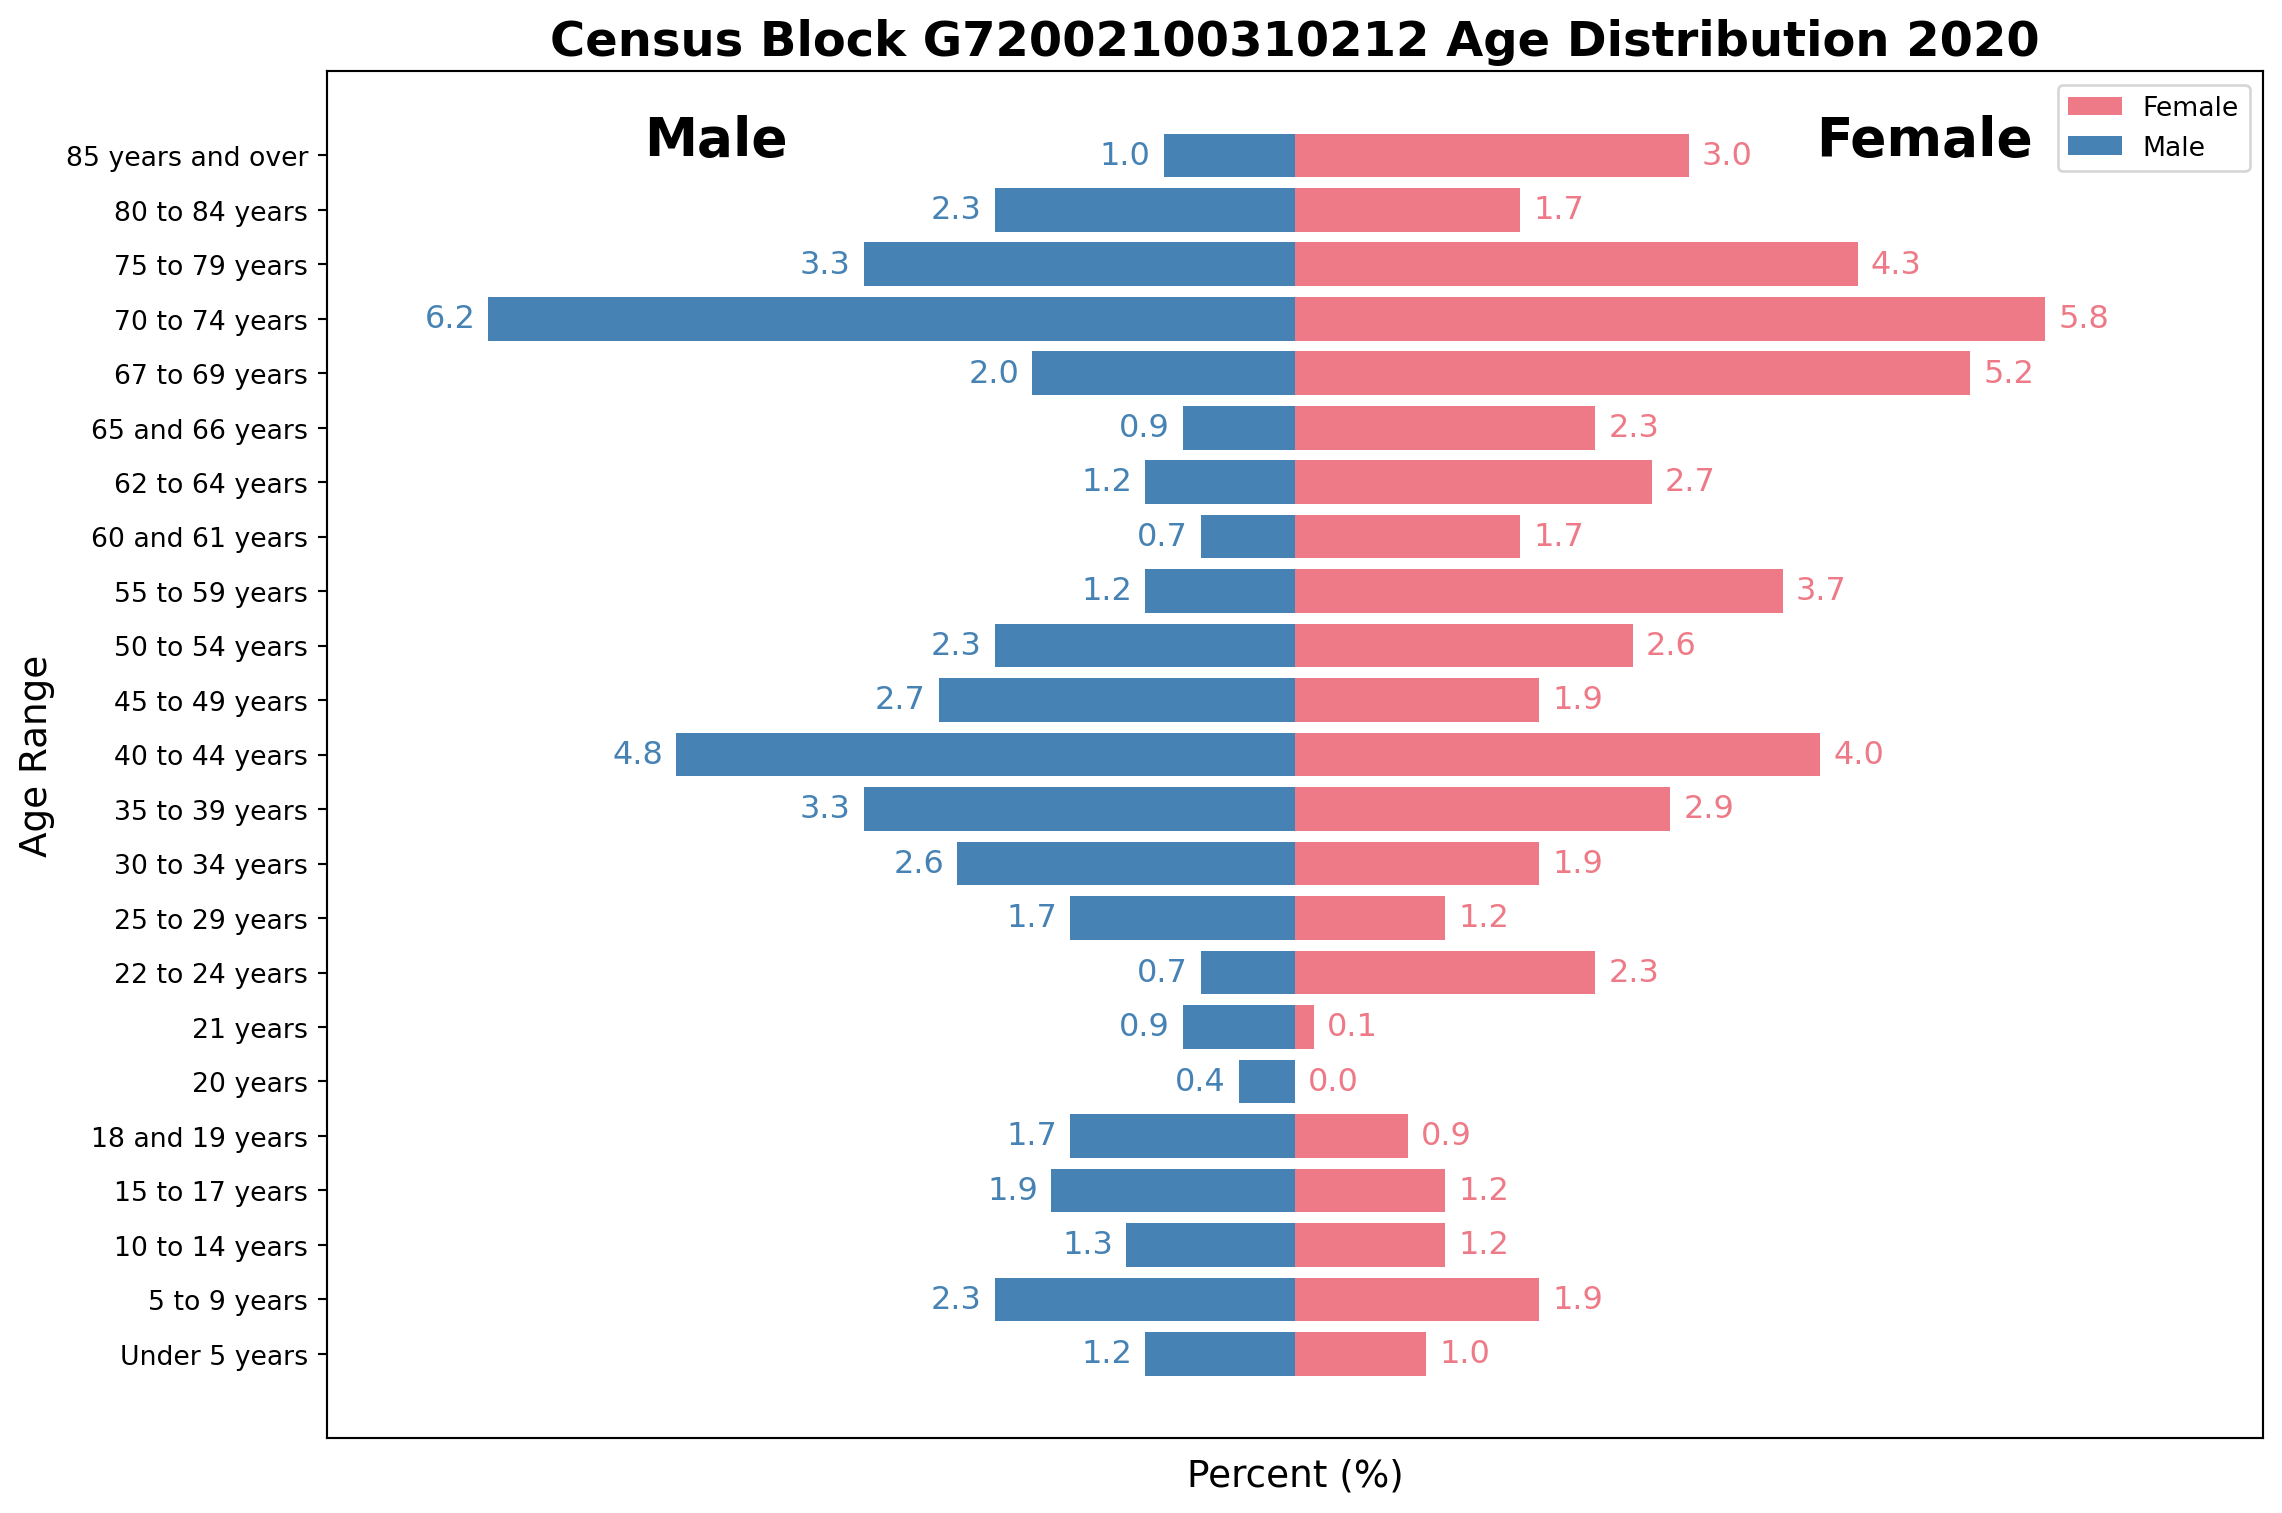

In [28]:
# --- STEP 1: Select a census block by GEOID ---
block_id = "G72002100310212"  # Replace with any valid GEOID
block_df = merged_df[merged_df["GISJOIN"] == block_id].copy()

assert len(block_df) == 1, f"Expected one row for GEOID {block_id}, but got {len(block_df)}"

# --- STEP 2: Identify male and female age columns ---
male_cols = [col for col in block_df.columns if col.startswith("Male:")]
female_cols = [col for col in block_df.columns if col.startswith("Female:")]
age_labels = [col.split(": ")[1] for col in male_cols]  # Extract age ranges

# --- STEP 3: Get values (choose percent or raw counts) ---
use_percent = True  # Set to False if you want raw counts

if use_percent:
    total_pop = block_df[male_cols + female_cols].sum(axis=1).values[0]
    male_vals = (block_df[male_cols].values[0] / total_pop) * 100
    female_vals = (block_df[female_cols].values[0] / total_pop) * 100
    value_label = "Percent (%)"
else:
    male_vals = block_df[male_cols].values[0]
    female_vals = block_df[female_cols].values[0]
    value_label = "Population Count"

# --- STEP 4: Build plotting dataframe ---
population = pd.DataFrame({
    "Age": age_labels,
    "Male": male_vals,
    "Female": female_vals
})

population["Female_Left"] = 0
population["Female_Width"] = population["Female"]
population["Male_Left"] = -population["Male"]
population["Male_Width"] = population["Male"]

# --- STEP 5: Plot the pyramid ---
fig = plt.figure(figsize=(12, 8))

plt.barh(y=population["Age"], width=population["Female_Width"], color="#ee7a87", label="Female")
plt.barh(y=population["Age"], width=population["Male_Width"], left=population["Male_Left"],
         color="#4682b4", label="Male")

plt.text(-5, len(population) - 1, "Male", fontsize=20, fontweight="bold")
plt.text(4, len(population) - 1, "Female", fontsize=20, fontweight="bold")

for idx in range(len(population)):
    plt.text(x=population["Male_Left"][idx] - 0.1, y=idx, s=f"{round(population['Male'][idx], 1)}",
             ha="right", va="center", fontsize=12, color="#4682b4")
    plt.text(x=population["Female_Width"][idx] + 0.1, y=idx, s=f"{round(population['Female'][idx], 1)}",
             ha="left", va="center", fontsize=12, color="#ee7a87")

xlim_val = max(population[["Male", "Female"]].max()) * 1.2
plt.xlim(-xlim_val, xlim_val)
plt.xticks([])
plt.legend(loc="best")

plt.xlabel(value_label, fontsize=14)
plt.ylabel("Age Range", fontsize=14)
plt.title(f"Census Block {block_id} Age Distribution 2020", fontsize=18, fontweight="bold")
plt.tight_layout()
plt.show()

### Select a large Block Group

Age pyramids can also be generated by subsetting a Census Block Group by name, for example `NAME == "Block Group 1"` or "Block Group 3":

C:\Users\jmartine\AppData\Local\Temp\6\ipykernel_22600\4281272699.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



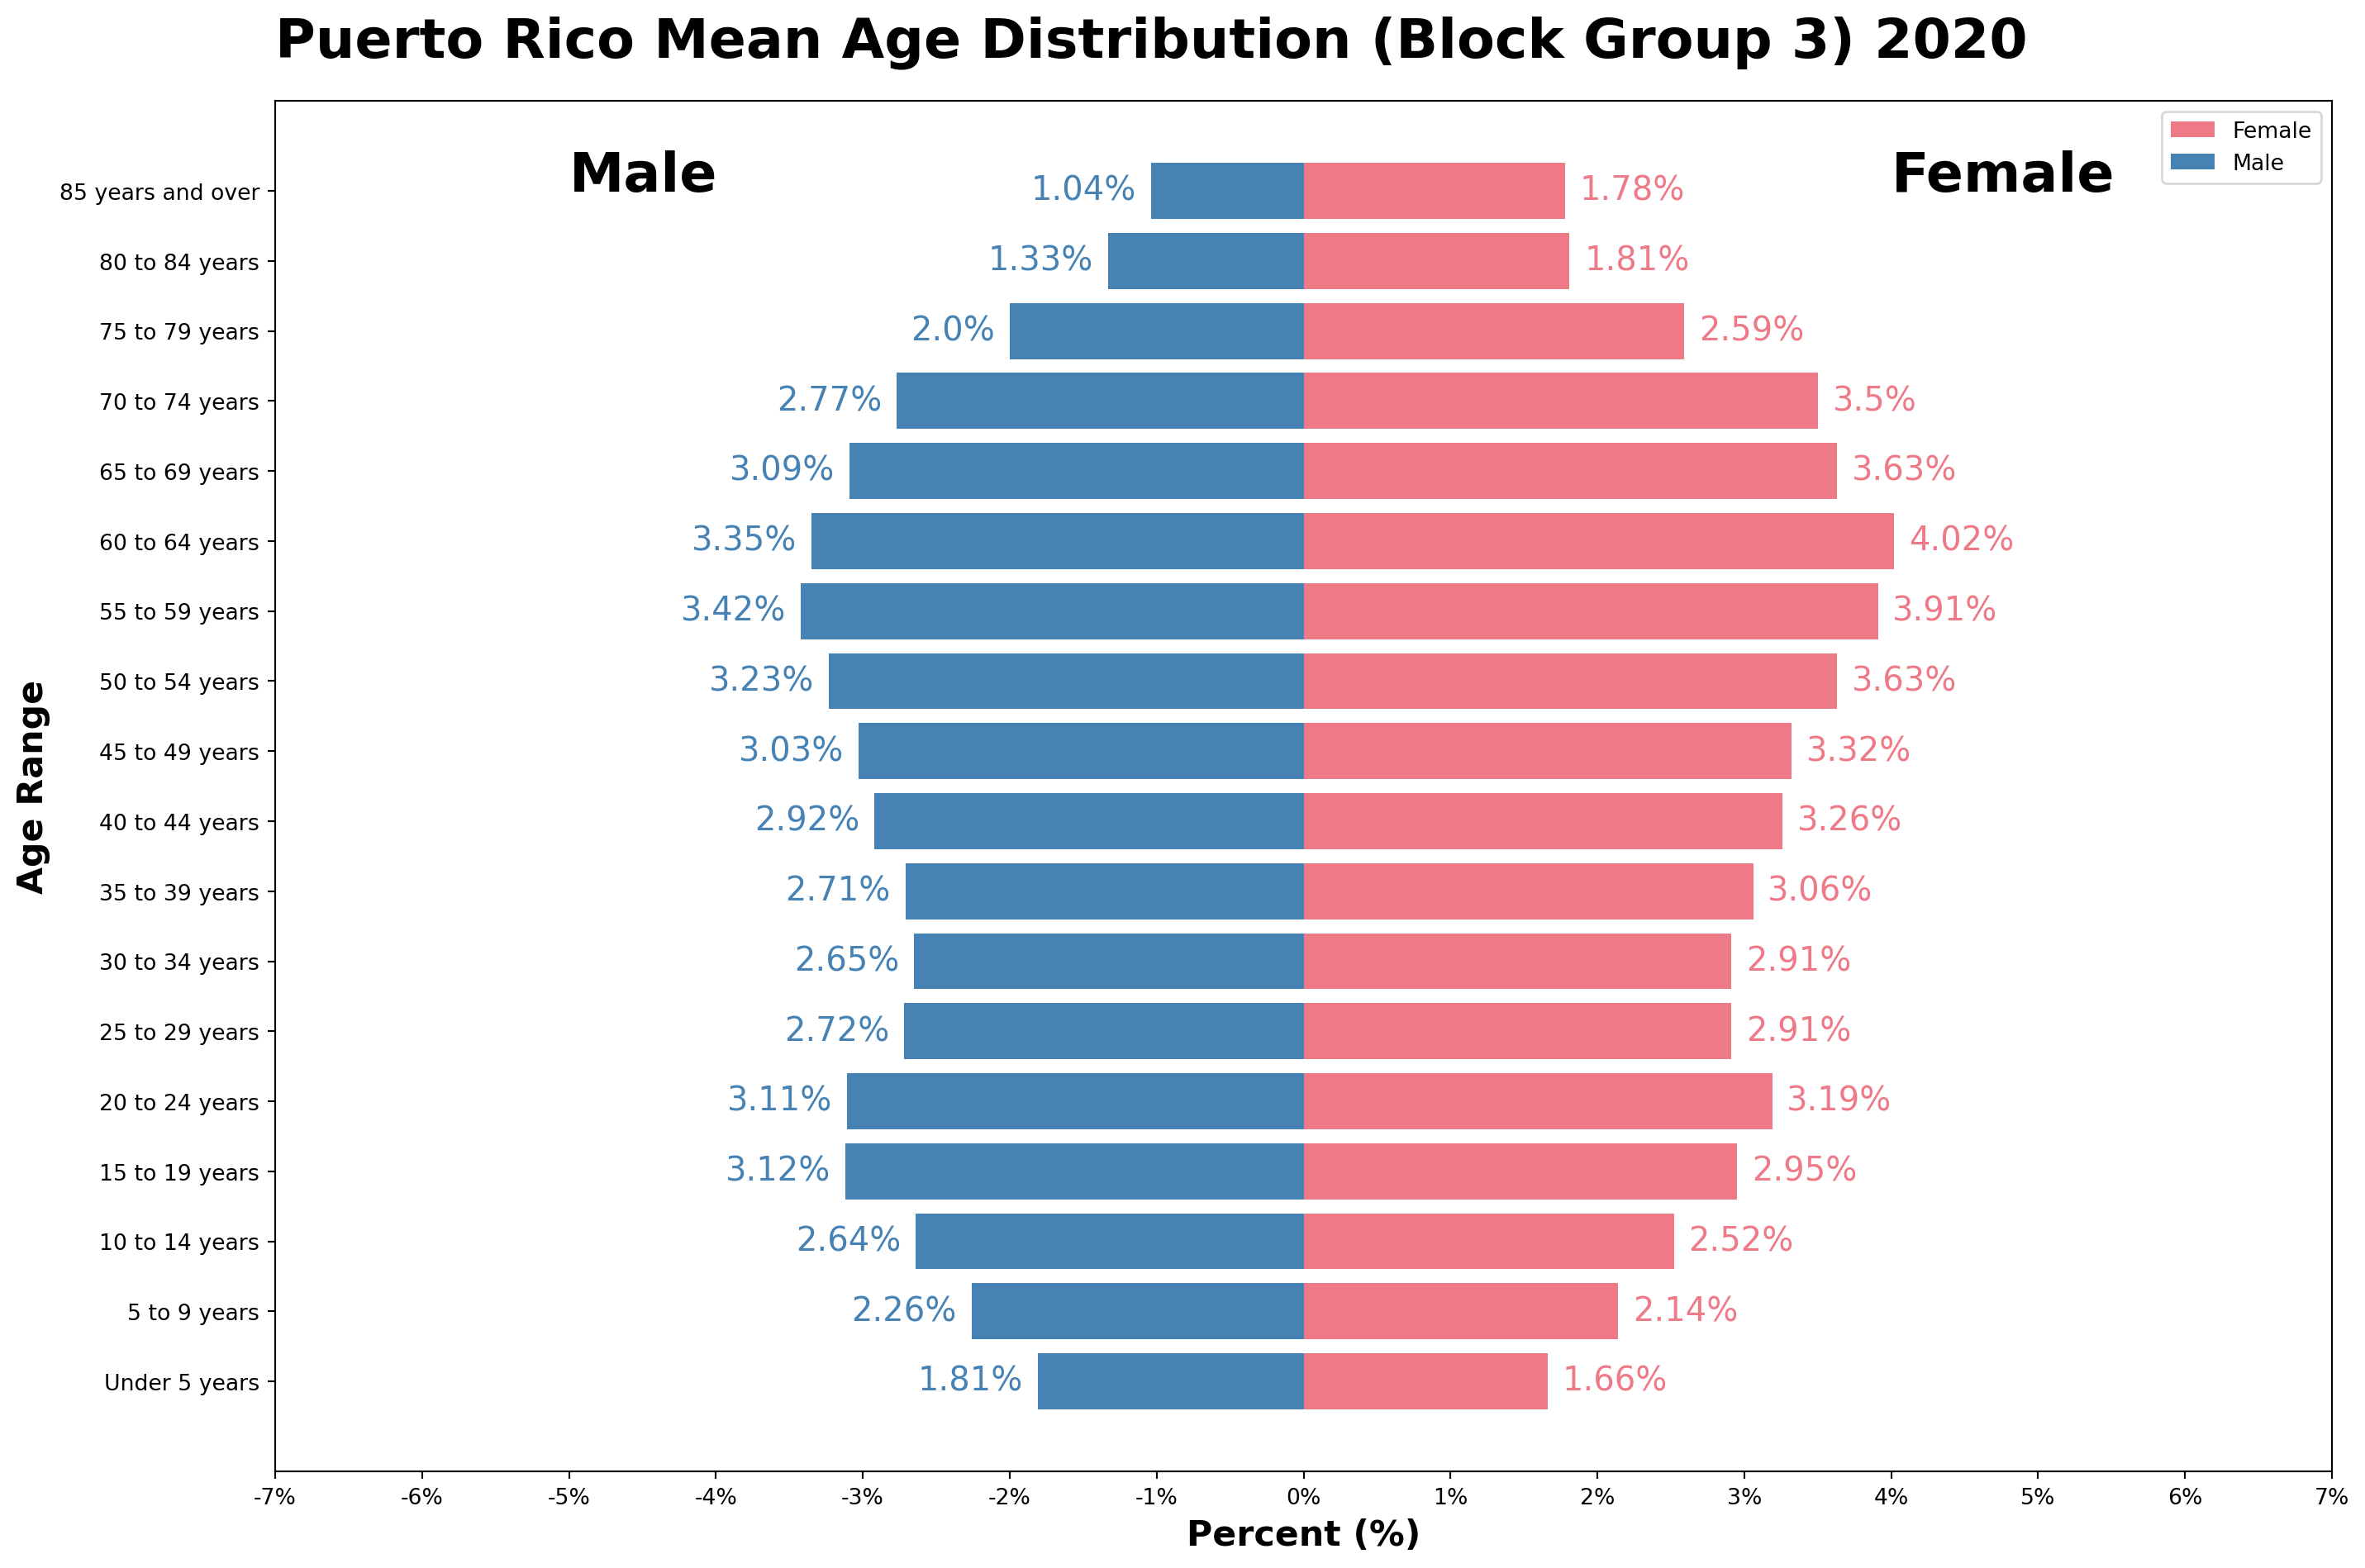

In [29]:
bg_name = "Block Group 3"

df_gb = merged_df[merged_df["NAME"] == bg_name ]


# 1. Define the relevant columns
joined_columns = [col for col in df_gb.columns if col.startswith("Male:") or col.startswith("Female:")]

# 2. Ensure Total_Population exists (if not, create it)
if "Total_Population" not in df_gb.columns:
    df_gb["Total_Population"] = df_gb[joined_columns].sum(axis=1)

# 3. Create DataFrame for percentage values
pct_df = df_gb[["Total_Population"] + joined_columns].copy()

# 4. Compute percentage for each age group column
for col in joined_columns:
    pct_df[f"{col}_pct"] = pct_df[col] / pct_df["Total_Population"] * 100

# 5. Drop original count columns, keep only percent columns
pct_df = pct_df[[col for col in pct_df.columns if col.endswith("_pct")]]

# 6. Separate by sex
male_age_percentages = []
female_age_percentages = []

for col in pct_df.columns:
    mean_pct = round(pct_df[col].mean(), 2)
    if col.startswith("Male:"):
        male_age_percentages.append(mean_pct)
    elif col.startswith("Female:"):
        female_age_percentages.append(mean_pct)

# 7. Extract age labels
new_age_columns = [col.split(": ")[1].replace("_pct", "") for col in pct_df.columns if col.startswith("Male:")]

# 8. Create the base DataFrame
population_df = pd.DataFrame({
    "Age": new_age_columns,
    "Male": male_age_percentages,
    "Female": female_age_percentages
})
population = population_df.copy()

# 9. Combine select age groups
# Combine 15-17 and 18-19 into 15-19
population.iloc[3, 0] = "15 to 19 years"
population.iloc[3, 1] += population.iloc[4, 1]
population.iloc[3, 2] += population.iloc[4, 2]
population = population.drop(index=4).reset_index(drop=True)

# Combine 20, 21, 22–24 into 20–24
population.iloc[4, 0] = "20 to 24 years"
population.iloc[4, 1] += population.iloc[5, 1] + population.iloc[6, 1]
population.iloc[4, 2] += population.iloc[5, 2] + population.iloc[6, 2]
population = population.drop(index=[5, 6]).reset_index(drop=True)

# Combine 60–61 and 62–64 into 60–64
population.iloc[12, 0] = "60 to 64 years"
population.iloc[12, 1] += population.iloc[13, 1]
population.iloc[12, 2] += population.iloc[13, 2]
population = population.drop(index=13).reset_index(drop=True)

# Combine 65–66 and 67–69 into 65–69
population.iloc[13, 0] = "65 to 69 years"
population.iloc[13, 1] += population.iloc[14, 1]
population.iloc[13, 2] += population.iloc[14, 2]
population = population.drop(index=14).reset_index(drop=True)

# 10. Prepare for plotting
population["Female_Left"] = 0
population["Female_Width"] = population["Female"]
population["Male_Left"] = -population["Male"]
population["Male_Width"] = population["Male"]

# Round for labels
population["Male"] = population["Male"].round(2)
population["Female"] = population["Female"].round(2)

# 11. Plot the population pyramid
fig = plt.figure(figsize=(15, 10))

plt.barh(y=population["Age"], width=population["Female_Width"], color="#ee7a87", label="Female")
plt.barh(y=population["Age"], width=population["Male_Width"], left=population["Male_Left"],
         color="#4682b4", label="Male")

plt.text(-5, len(population) - 1, "Male", fontsize=25, fontweight="bold")
plt.text(4, len(population) - 1, "Female", fontsize=25, fontweight="bold")

# Add labels
for idx in range(len(population)):
    plt.text(x=population["Male_Left"][idx] - 0.1, y=idx, s="{}%".format(population["Male"][idx]),
             ha="right", va="center", fontsize=15, color="#4682b4")
    plt.text(x=population["Female_Width"][idx] + 0.1, y=idx, s="{}%".format(population["Female"][idx]),
             ha="left", va="center", fontsize=15, color="#ee7a87")

plt.xlim(-7, 7)
plt.xticks(range(-7, 8), ["{}%".format(i) for i in range(-7, 8)])
plt.legend(loc="best")
plt.xlabel("Percent (%)", fontsize=16, fontweight="bold")
plt.ylabel("Age Range", fontsize=16, fontweight="bold")
plt.title(f"Puerto Rico Mean Age Distribution ({bg_name}) 2020", loc="left", pad=20, fontsize=25, fontweight="bold")

plt.tight_layout()
plt.show()

## Interactinv with ArcGIS Online Portal

ArcGIS Online or Enterprise portal are tools that retrieve a specific hosted feature layers. We use the `arcgis` package to find features of U.S. counties (2020), and filter it to include only features where STATEFP = '72', which corresponds to Puerto Rico. The resulting spatial data is converted into a Spatially Enabled DataFrame (sedf) using ArcGIS' Python API.

In [30]:
# Get the layer from the published data

# Connect to ArcGIS Online (anonymous session)
gis = GIS()

# Access a specific hosted feature layer by its Item ID
layer = gis.content.get("3132216944b249a08d13b1aa0ee6fda2").layers[0]  # PR counties 2020 layer

# Query Puerto Rico counties using the state FIPS code '72'
sedf = layer.query(where="STATEFP = '72'").sdf  # Convert to Spatially Enabled DataFrame

We can merge the spatial county feature layer for Puerto Rico (2020) with your  demographic data (2010–2020) using the `GISJOIN` field as a common geographic identifier. The result, `pr_sedf_ipums`, is a Spatially Enabled DataFrame that contains both geometry and attribute data—making it ready for mapping or spatial analysis!


In [31]:
#Merge the feature to the merged 2010-2020 df
pr_sedf_ipums = sedf.merge(merged_df, on = "GISJOIN", how = "inner")

## Summarizing and Plotting DAta

Let's combine the Block Groups into Counties and Map the results.



## HIEU SUMMARIZE merged_df TO COUNTY (pd_county_df) using "sum" to add:  "Total_Population", "Male", "Female", "Pop60plus_total",  "Total_Housing_Units", "Occupied", "Vacant",  for all have _2010 and _2020 at the end. 



### Hieu Recalculate CHange


In [32]:
# pr_county_df["AgedRatio_2010"] = pr_county_df["Pop60plus_total_2010"] /  pr_county_df["Total_Population_2010"]
# pr_county_df["VacantRatio_2010"] = pr_county_df["Vacant_2010"] /  pr_county_df["Total_Housing_Units_2010"]


# pr_county_df["AgedRatio_2020"] = pr_county_df["Pop60plus_total_2020"] /  pr_county_df["Total_Population_2020"]
# pr_county_df["VacantRatio_2020"] = pr_county_df["Vacant_2020"] /  pr_county_df["Total_Housing_Units_2020"]

In [33]:
# pr_county_df["Total_Pop_Change"] = pr_county_df["Total_Population_2020"] - pr_county_df["Total_Population_2010"]
# pr_county_df["Pop60plus_Change"] = pr_county_df["Pop60plus_total_2020"] - pr_county_df["Pop60plus_total_2010"]
# pr_county_df["Vacant_Change"] = (pr_county_df["Vacant_2020"] - pr_county_df["Vacant_2010"])

# pr_county_df["VacantRatio_Change"] = pr_county_df["VacantRatio_2020"] - pr_county_df["VacantRatio_2010"]

# pr_county_df["AgedRatio_Change"] = (pr_county_df["AgedRatio_2020"] - pr_county_df["AgedRatio_2010"])


# pr_county_df

In [34]:
# # Compute means and standard deviations
# means = pr_county_df[vars_to_plot].mean()
# stds = pr_county_df[vars_to_plot].std()

# # Create z-score columns
# for var in vars_to_plot:
#     z_col = var.replace("_Change", "_dz")
#     pr_county_df[z_col] = (pr_county_df[var] - means[var]) / stds[var]

##


In [35]:
# Filter for lowest and highest vacancy quantile groups
# lowest = pr_county_df[pr_county_df["AgedRatio_dz"] == 1]
# highest = pr_county_df[pr_county_df["AgedRatio_dz"] == 5]


# # Use COUNTYA for grouping (could be COUNTY if preferred)
# # Step 1: Find common counties between the two groups
# common_counties = sorted(
#     set(lowest["COUNTY"]).intersection(set(highest["COUNTY"]))
# )

# # Step 2: Group and sum vacant housing units for 2010 and 2020, reindexed by common counties
# vacant_low_2010 = lowest[lowest["COUNTY"].isin(common_counties)] \
#     .groupby("COUNTY")["VacantRatio_2010"].sum().reindex(common_counties)
# vacant_low_2020 = lowest[lowest["COUNTYA"].isin(common_counties)] \
#     .groupby("COUNTY")["VacantRatio_2020"].sum().reindex(common_counties)

# vacant_high_2010 = highest[highest["COUNTY"].isin(common_counties)] \
#     .groupby("COUNTY")["VacantRatio_2010"].sum().reindex(common_counties)
# vacant_high_2020 = highest[highest["COUNTY"].isin(common_counties)] \
#     .groupby("COUNTY")["VacantRatio_2020"].sum().reindex(common_counties)

# # Step 3: Plot
# x = np.arange(len(common_counties))  # consistent X positions

# fig, ax = plt.subplots(figsize=(12, 6))

# ax.scatter(x, vacant_low_2010.values, label='Lowest Age Ratio 2010', color='skyblue', marker='o', s=60)
# ax.scatter(x, vacant_low_2020.values, label='Lowest Age Ratio 2020', color='blue', marker='o', s=60)
# ax.scatter(x, vacant_high_2010.values, label='Highest Age Ratio 2010', color='orange', marker='^', s=60)
# ax.scatter(x, vacant_high_2020.values, label='Highest Age Ratio 2020', color='darkred', marker='^', s=60)

# # Formatting
# ax.set_ylabel('Vacant Housing Ratio')
# ax.set_xlabel('County (COUNTYA)')
# ax.set_title('Vacant Housing Units by County: Lowest vs Highest Age Ratio Change Quantile (2010 & 2020)')
# ax.set_xticks(x)
# ax.set_xticklabels(common_counties, rotation=90)
# ax.legend()
# ax.grid(True, axis='y')

# plt.tight_layout()
# plt.show()


# Mapping data



## Start preprocessing the Census data downloaded from IPUMS API

To map the shapefile to the map, we have to publish the shapefile as feature layer on MapViewer on ArcGIS Online by adding layer from your shapefile zipped folder. 

This lesson is public facing so we already published the layers for the learners.


In [36]:
# # Explicit interactive authentication
# gis = GIS("https://www.arcgis.com", authenticate='interactive')


# # Get the layer from the published data

# results = gis.content.search("Census County Esri_US_Federal_Data", item_type="Feature Layer")
# for r in results:
#     print(r)

Select the position of the "Cansus Zip Code Tabulation Areas" layer starting with position the first position as `0`. 

In [37]:
# #select the appropiate item
# zip_item = results[3]
# item_id = zip_item.id
# print(f"Title: {zip_item.title}")
# print(f"ID: {item_id}")


With the item's ID (ccfe5a9e3eea4ec68b7945b610422b0a) from ablove, we can  use the layers for analysis

In [38]:
# from arcgis.features import FeatureLayer
# # Authenticate interactively
# gis = GIS("https://www.arcgis.com", authenticate='interactive')
# layer = gis.content.get(item_id).layers[0] # The layer of PR county 2020 published to the portal
# # Print all field names
# field_names = [field['name'] for field in layer.properties.fields]
# print(field_names)
# print(layer.url)
# layer = FeatureLayer(layer.url)

## Hieu Change this for Change this for County to display the "COUNTY" name in the label and either VacancyRatio_dz 


In [39]:
# # Build unique value info entries
# unique_value_infos = []
# for i in range(5):
#     unique_value_infos.append({
#         "value": i + 1,
#         "label": quantile_labels[i],
#         "symbol": symbols[i]
#     })

# # Define the unique value renderer
# pr_uvr = {
#     "type": "uniqueValue",
#     "field1": "Total_Population",
#     "uniqueValueInfos": unique_value_infos
# }

# # Define labeling info
# pr_labeling_info = [
#     {
#         "labelExpression": "[NAME_x]",
#         "labelPlacement": "esriServerPolygonPlacementAlwaysHorizontal",
#         "repeatLabel": True,
#         "symbol": {
#             "type": "esriTS",
#             "color": [0, 0, 0, 255],
#             "font": {
#                 "family": "Arial",
#                 "size": 12
#             },
#             "horizontalAlignment": "center",
#             "kerning": True
#         }
#     }
# ]

# # Layer display options
# pr_options_dict = {
#     "showLabels": True,
#     "layerDefinition": {
#         "drawingInfo": {
#             "labelingInfo": pr_labeling_info,
#             "renderer": pr_uvr
#         }
#     },
#     "opacity": 0.5,
#     "title": "Vacant Housing Units Decadal Change"
# }



# gis = GIS()
# m1 = gis.map("Puerto Rico") 
 
# m1.content.add(pr_sedf_ipums, options = pr_options_dict) 
# # update the legend label for LECZ layer in Notebooks
 
# m1.legend.enabled = True

# m1

# Search for LECZ MERIT-DEM layer on ArcGIS Online's Living Atlas portal.

With the arcgis package, we can search online for the polygons of the LECZ areas in Puerto Rico


## Hieu  Overlay LECZ polygons and add a classification column of 1 or 0 to the counties dataframe

## Plot bloxplot showing differences in Vacant and Aged Ratios in the two groups (in lecz, not in lecz)

## Display map with counties in LEZ only with colors displaying AgedRatio_dz
